In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# For conversion
from skimage.color import lab2rgb, rgb2lab, rgb2gray
from skimage import io
# For everything
import torch
import torch.nn as nn
import torch.nn.functional as F
# For our model
import torchvision.models as models
from torchvision import datasets, transforms
# For utilities
import os, shutil, time
# For progress visualization
from tqdm.notebook import tqdm
# For mixed-precision training
from apex import amp

from matplotlib.image import imread
from pathlib import Path
import glob
from PIL import Image

from sklearn.metrics import r2_score
from torch.utils.data import Dataset, DataLoader

from IPython.display import Image, display

In [2]:
use_gpu = torch.cuda.is_available()

# Download and unzip data

In [6]:
# Download and unzip (use validation set first)
# !wget http://data.csail.mit.edu/places/places365/val_256.tar

--2020-06-11 05:15:15--  http://data.csail.mit.edu/places/places365/val_256.tar
Resolving data.csail.mit.edu (data.csail.mit.edu)... 128.52.129.40
Connecting to data.csail.mit.edu (data.csail.mit.edu)|128.52.129.40|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 525158400 (501M) [application/octet-stream]
Saving to: ‘val_256.tar’

val_256.tar         100%[===================>] 500.83M  6.83MB/s    in 2m 39s  

2020-06-11 05:17:54 (3.14 MB/s) - ‘val_256.tar’ saved [525158400/525158400]

tar (child): val_256.tar.gz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [33]:
!tar -xvf val_256.tar

val_256/
val_256/Places365_val_00035900.jpg
val_256/Places365_val_00035572.jpg
val_256/Places365_val_00002949.jpg
val_256/Places365_val_00007265.jpg
val_256/Places365_val_00019005.jpg
val_256/Places365_val_00027775.jpg
val_256/Places365_val_00015062.jpg
val_256/Places365_val_00014185.jpg
val_256/Places365_val_00026692.jpg
val_256/Places365_val_00006857.jpg
val_256/Places365_val_00006425.jpg
val_256/Places365_val_00034332.jpg
val_256/Places365_val_00014622.jpg
val_256/Places365_val_00026135.jpg
val_256/Places365_val_00018645.jpg
val_256/Places365_val_00006382.jpg
val_256/Places365_val_00034495.jpg
val_256/Places365_val_00017090.jpg
val_256/Places365_val_00009925.jpg
val_256/Places365_val_00009557.jpg
val_256/Places365_val_00025787.jpg
val_256/Places365_val_00005530.jpg
val_256/Places365_val_00005942.jpg
val_256/Places365_val_00032579.jpg
val_256/Places365_val_00017737.jpg
val_256/Places365_val_00025020.jpg
val_256/Places365_val_00012069.jpg
val_256/Places365_val_00005297.jpg
val_256/Pla

val_256/Places365_val_00007894.jpg
val_256/Places365_val_00015146.jpg
val_256/Places365_val_00027651.jpg
val_256/Places365_val_00010618.jpg
val_256/Places365_val_00007341.jpg
val_256/Places365_val_00030308.jpg
val_256/Places365_val_00019686.jpg
val_256/Places365_val_00035456.jpg
val_256/Places365_val_00035824.jpg
val_256/Places365_val_00011058.jpg
val_256/Places365_val_00026011.jpg
val_256/Places365_val_00014706.jpg
val_256/Places365_val_00018761.jpg
val_256/Places365_val_00034216.jpg
val_256/Places365_val_00031548.jpg
val_256/Places365_val_00006501.jpg
val_256/Places365_val_00006973.jpg
val_256/Places365_val_00025104.jpg
val_256/Places365_val_00017613.jpg
val_256/Places365_val_00029163.jpg
val_256/Places365_val_00009473.jpg
val_256/Places365_val_00009801.jpg
val_256/Places365_val_00005866.jpg
val_256/Places365_val_00005414.jpg
val_256/Places365_val_00004981.jpg
val_256/Places365_val_00028723.jpg
val_256/Places365_val_00008594.jpg
val_256/Places365_val_00016053.jpg
val_256/Places365_va

val_256/Places365_val_00017046.jpg
val_256/Places365_val_00008466.jpg
val_256/Places365_val_00008814.jpg
val_256/Places365_val_00033448.jpg
val_256/Places365_val_00004873.jpg
val_256/Places365_val_00004401.jpg
val_256/Places365_val_00036316.jpg
val_256/Places365_val_00016606.jpg
val_256/Places365_val_00013158.jpg
val_256/Places365_val_00024111.jpg
val_256/Places365_val_00028176.jpg
val_256/Places365_val_00007514.jpg
val_256/Places365_val_00007966.jpg
val_256/Places365_val_00035203.jpg
val_256/Places365_val_00015713.jpg
val_256/Places365_val_00027004.jpg
val_256/Places365_val_00019774.jpg
val_256/Places365_val_00003878.jpg
val_256/Places365_val_00034443.jpg
val_256/Places365_val_00034831.jpg
val_256/Places365_val_00006354.jpg
val_256/Places365_val_00018693.jpg
val_256/Places365_val_00018134.jpg
val_256/Places365_val_00006881.jpg
val_256/Places365_val_00026644.jpg
val_256/Places365_val_00014153.jpg
val_256/Places365_val_00003133.jpg
val_256/Places365_val_00031624.jpg
val_256/Places365_va

val_256/Places365_val_00010270.jpg
val_256/Places365_val_00019549.jpg
val_256/Places365_val_00035799.jpg
val_256/Places365_val_00012060.jpg
val_256/Places365_val_00025029.jpg
val_256/Places365_val_00020777.jpg
val_256/Places365_val_00000267.jpg
val_256/Places365_val_00032570.jpg
val_256/Places365_val_00032902.jpg
val_256/Places365_val_00005539.jpg
val_256/Places365_val_00017099.jpg
val_256/Places365_val_00021137.jpg
val_256/Places365_val_00024669.jpg
val_256/Places365_val_00013620.jpg
val_256/Places365_val_00033497.jpg
val_256/Places365_val_00001380.jpg
val_256/Places365_val_00021690.jpg
val_256/Places365_val_00013187.jpg
val_256/Places365_val_00004379.jpg
val_256/Places365_val_00033330.jpg
val_256/Places365_val_00001427.jpg
val_256/Places365_val_00001855.jpg
val_256/Places365_val_00022022.jpg
val_256/Places365_val_00010735.jpg
val_256/Places365_val_00030582.jpg
val_256/Places365_val_00002295.jpg
val_256/Places365_val_00022785.jpg
val_256/Places365_val_00010092.jpg
val_256/Places365_va

val_256/Places365_val_00019940.jpg
val_256/Places365_val_00006112.jpg
val_256/Places365_val_00034605.jpg
val_256/Places365_val_00023889.jpg
val_256/Places365_val_00018372.jpg
val_256/Places365_val_00014315.jpg
val_256/Places365_val_00026870.jpg
val_256/Places365_val_00026402.jpg
val_256/Places365_val_00011839.jpg
val_256/Places365_val_00005007.jpg
val_256/Places365_val_00000759.jpg
val_256/Places365_val_00009060.jpg
val_256/Places365_val_00029902.jpg
val_256/Places365_val_00029570.jpg
val_256/Places365_val_00020249.jpg
val_256/Places365_val_00017200.jpg
val_256/Places365_val_00025517.jpg
val_256/Places365_val_00025965.jpg
val_256/Places365_val_00024882.jpg
val_256/Places365_val_00008620.jpg
val_256/Places365_val_00036150.jpg
val_256/Places365_val_00028497.jpg
val_256/Places365_val_00001119.jpg
val_256/Places365_val_00004647.jpg
val_256/Places365_val_00024357.jpg
val_256/Places365_val_00016440.jpg
val_256/Places365_val_00016832.jpg
val_256/Places365_val_00021409.jpg
val_256/Places365_va

val_256/Places365_val_00008502.jpg
val_256/Places365_val_00008970.jpg
val_256/Places365_val_00004917.jpg
val_256/Places365_val_00004565.jpg
val_256/Places365_val_00036272.jpg
val_256/Places365_val_00016762.jpg
val_256/Places365_val_00024075.jpg
val_256/Places365_val_00028012.jpg
val_256/Places365_val_00022199.jpg
val_256/Places365_val_00030439.jpg
val_256/Places365_val_00007470.jpg
val_256/Places365_val_00007802.jpg
val_256/Places365_val_00035367.jpg
val_256/Places365_val_00015677.jpg
val_256/Places365_val_00010129.jpg
val_256/Places365_val_00027160.jpg
val_256/Places365_val_00019610.jpg
val_256/Places365_val_00002489.jpg
val_256/Places365_val_00034527.jpg
val_256/Places365_val_00034955.jpg
val_256/Places365_val_00006230.jpg
val_256/Places365_val_00031279.jpg
val_256/Places365_val_00026087.jpg
val_256/Places365_val_00014790.jpg
val_256/Places365_val_00034280.jpg
val_256/Places365_val_00018050.jpg
val_256/Places365_val_00006597.jpg
val_256/Places365_val_00026720.jpg
val_256/Places365_va

val_256/Places365_val_00008357.jpg
val_256/Places365_val_00024187.jpg
val_256/Places365_val_00021447.jpg
val_256/Places365_val_00021835.jpg
val_256/Places365_val_00013350.jpg
val_256/Places365_val_00024319.jpg
val_256/Places365_val_00033640.jpg
val_256/Places365_val_00004609.jpg
val_256/Places365_val_00001157.jpg
val_256/Places365_val_00013885.jpg
val_256/Places365_val_00025559.jpg
val_256/Places365_val_00012510.jpg
val_256/Places365_val_00012962.jpg
val_256/Places365_val_00020207.jpg
val_256/Places365_val_00009789.jpg
val_256/Places365_val_00029299.jpg
val_256/Places365_val_00000717.jpg
val_256/Places365_val_00005049.jpg
val_256/Places365_val_00032000.jpg
val_256/Places365_val_00011877.jpg
val_256/Places365_val_00011405.jpg
val_256/Places365_val_00023312.jpg
val_256/Places365_val_00003602.jpg
val_256/Places365_val_00031115.jpg
val_256/Places365_val_00015969.jpg
val_256/Places365_val_00022920.jpg
val_256/Places365_val_00022552.jpg
val_256/Places365_val_00010245.jpg
val_256/Places365_va

val_256/Places365_val_00023532.jpg
val_256/Places365_val_00023940.jpg
val_256/Places365_val_00011225.jpg
val_256/Places365_val_00031092.jpg
val_256/Places365_val_00003785.jpg
val_256/Places365_val_00002662.jpg
val_256/Places365_val_00030175.jpg
val_256/Places365_val_00019889.jpg
val_256/Places365_val_00010465.jpg
val_256/Places365_val_00010817.jpg
val_256/Places365_val_00022372.jpg
val_256/Places365_val_00001777.jpg
val_256/Places365_val_00004029.jpg
val_256/Places365_val_00033060.jpg
val_256/Places365_val_00016589.jpg
val_256/Places365_val_00036099.jpg
val_256/Places365_val_00024539.jpg
val_256/Places365_val_00013902.jpg
val_256/Places365_val_00013570.jpg
val_256/Places365_val_00021267.jpg
val_256/Places365_val_00020380.jpg
val_256/Places365_val_00012497.jpg
val_256/Places365_val_00032620.jpg
val_256/Places365_val_00005669.jpg
val_256/Places365_val_00000137.jpg
val_256/Places365_val_00020855.jpg
val_256/Places365_val_00020427.jpg
val_256/Places365_val_00012330.jpg
val_256/Places365_va

val_256/Places365_val_00017944.jpg
val_256/Places365_val_00017536.jpg
val_256/Places365_val_00029246.jpg
val_256/Places365_val_00005096.jpg
val_256/Places365_val_00026493.jpg
val_256/Places365_val_00014384.jpg
val_256/Places365_val_00034133.jpg
val_256/Places365_val_00006624.jpg
val_256/Places365_val_00026334.jpg
val_256/Places365_val_00014423.jpg
val_256/Places365_val_00014851.jpg
val_256/Places365_val_00023818.jpg
val_256/Places365_val_00034694.jpg
val_256/Places365_val_00006183.jpg
val_256/Places365_val_00018836.jpg
val_256/Places365_val_00018444.jpg
val_256/Places365_val_00007064.jpg
val_256/Places365_val_00035773.jpg
val_256/Places365_val_00019204.jpg
val_256/Places365_val_00015263.jpg
val_256/Places365_val_00027574.jpg
val_256/Places365_val_00027906.jpg
val_256/Places365_val_00025764.jpg
val_256/Places365_val_00017073.jpg
val_256/Places365_val_00029703.jpg
val_256/Places365_val_00009213.jpg
val_256/Places365_val_00000958.jpg
val_256/Places365_val_00005274.jpg
val_256/Places365_va

val_256/Places365_val_00026439.jpg
val_256/Places365_val_00011470.jpg
val_256/Places365_val_00011802.jpg
val_256/Places365_val_00006129.jpg
val_256/Places365_val_00031160.jpg
val_256/Places365_val_00003677.jpg
val_256/Places365_val_00014489.jpg
val_256/Places365_val_00010230.jpg
val_256/Places365_val_00027279.jpg
val_256/Places365_val_00022527.jpg
val_256/Places365_val_00022955.jpg
val_256/Places365_val_00002790.jpg
val_256/Places365_val_00030087.jpg
val_256/Places365_val_00019509.jpg
val_256/Places365_val_00010597.jpg
val_256/Places365_val_00022280.jpg
val_256/Places365_val_00002037.jpg
val_256/Places365_val_00030720.jpg
val_256/Places365_val_00007769.jpg
val_256/Places365_val_00012104.jpg
val_256/Places365_val_00020613.jpg
val_256/Places365_val_00000303.jpg
val_256/Places365_val_00032414.jpg
val_256/Places365_val_00032866.jpg
val_256/Places365_val_00009848.jpg
val_256/Places365_val_00021053.jpg
val_256/Places365_val_00013744.jpg
val_256/Places365_val_00033981.jpg
val_256/Places365_va

val_256/Places365_val_00015605.jpg
val_256/Places365_val_00027112.jpg
val_256/Places365_val_00030839.jpg
val_256/Places365_val_00007402.jpg
val_256/Places365_val_00007870.jpg
val_256/Places365_val_00035315.jpg
val_256/Places365_val_00017531.jpg
val_256/Places365_val_00017943.jpg
val_256/Places365_val_00020578.jpg
val_256/Places365_val_00025226.jpg
val_256/Places365_val_00005091.jpg
val_256/Places365_val_00029241.jpg
val_256/Places365_val_00009751.jpg
val_256/Places365_val_00017296.jpg
val_256/Places365_val_00025581.jpg
val_256/Places365_val_00005736.jpg
val_256/Places365_val_00029994.jpg
val_256/Places365_val_00000068.jpg
val_256/Places365_val_00028873.jpg
val_256/Places365_val_00028401.jpg
val_256/Places365_val_00033698.jpg
val_256/Places365_val_00024466.jpg
val_256/Places365_val_00024814.jpg
val_256/Places365_val_00021338.jpg
val_256/Places365_val_00016371.jpg
val_256/Places365_val_00001628.jpg
val_256/Places365_val_00004176.jpg
val_256/Places365_val_00013388.jpg
val_256/Places365_va

val_256/Places365_val_00017256.jpg
val_256/Places365_val_00025933.jpg
val_256/Places365_val_00025541.jpg
val_256/Places365_val_00012508.jpg
val_256/Places365_val_00005051.jpg
val_256/Places365_val_00032018.jpg
val_256/Places365_val_00029281.jpg
val_256/Places365_val_00017983.jpg
val_256/Places365_val_00009036.jpg
val_256/Places365_val_00018324.jpg
val_256/Places365_val_00014343.jpg
val_256/Places365_val_00026454.jpg
val_256/Places365_val_00026826.jpg
val_256/Places365_val_00006144.jpg
val_256/Places365_val_00018483.jpg
val_256/Places365_val_00034653.jpg
val_256/Places365_val_00014896.jpg
val_256/Places365_val_00027214.jpg
val_256/Places365_val_00015503.jpg
val_256/Places365_val_00015971.jpg
val_256/Places365_val_00022938.jpg
val_256/Places365_val_00019916.jpg
val_256/Places365_val_00019564.jpg
val_256/Places365_val_00010988.jpg
val_256/Places365_val_00035013.jpg
val_256/Places365_val_00007704.jpg
val_256/Places365_val_00029147.jpg
val_256/Places365_val_00005397.jpg
val_256/Places365_va

val_256/Places365_val_00003904.jpg
val_256/Places365_val_00003576.jpg
val_256/Places365_val_00023066.jpg
val_256/Places365_val_00026738.jpg
val_256/Places365_val_00011771.jpg
val_256/Places365_val_00018048.jpg
val_256/Places365_val_00034298.jpg
val_256/Places365_val_00033155.jpg
val_256/Places365_val_00001642.jpg
val_256/Places365_val_00021887.jpg
val_256/Places365_val_00028819.jpg
val_256/Places365_val_00021352.jpg
val_256/Places365_val_00013837.jpg
val_256/Places365_val_00013445.jpg
val_256/Places365_val_00025999.jpg
val_256/Places365_val_00000002.jpg
val_256/Places365_val_00032715.jpg
val_256/Places365_val_00012205.jpg
val_256/Places365_val_00017929.jpg
val_256/Places365_val_00020960.jpg
val_256/Places365_val_00020512.jpg
val_256/Places365_val_00003117.jpg
val_256/Places365_val_00031600.jpg
val_256/Places365_val_00006649.jpg
val_256/Places365_val_00011310.jpg
val_256/Places365_val_00026359.jpg
val_256/Places365_val_00023407.jpg
val_256/Places365_val_00023875.jpg
val_256/Places365_va

val_256/Places365_val_00025366.jpg
val_256/Places365_val_00005676.jpg
val_256/Places365_val_00000128.jpg
val_256/Places365_val_00009611.jpg
val_256/Places365_val_00012488.jpg
val_256/Places365_val_00024954.jpg
val_256/Places365_val_00024526.jpg
val_256/Places365_val_00021278.jpg
val_256/Places365_val_00016231.jpg
val_256/Places365_val_00036086.jpg
val_256/Places365_val_00028541.jpg
val_256/Places365_val_00028933.jpg
val_256/Places365_val_00004791.jpg
val_256/Places365_val_00024281.jpg
val_256/Places365_val_00016596.jpg
val_256/Places365_val_00008051.jpg
val_256/Places365_val_00001768.jpg
val_256/Places365_val_00004036.jpg
val_256/Places365_val_00006226.jpg
val_256/Places365_val_00034531.jpg
val_256/Places365_val_00034943.jpg
val_256/Places365_val_00003578.jpg
val_256/Places365_val_00014786.jpg
val_256/Places365_val_00026091.jpg
val_256/Places365_val_00006581.jpg
val_256/Places365_val_00018046.jpg
val_256/Places365_val_00034296.jpg
val_256/Places365_val_00014021.jpg
val_256/Places365_va

val_256/Places365_val_00035717.jpg
val_256/Places365_val_00030049.jpg
val_256/Places365_val_00007000.jpg
val_256/Places365_val_00024877.jpg
val_256/Places365_val_00024405.jpg
val_256/Places365_val_00016312.jpg
val_256/Places365_val_00028462.jpg
val_256/Places365_val_00028810.jpg
val_256/Places365_val_00008172.jpg
val_256/Places365_val_00004115.jpg
val_256/Places365_val_00029222.jpg
val_256/Places365_val_00009095.jpg
val_256/Places365_val_00020969.jpg
val_256/Places365_val_00017920.jpg
val_256/Places365_val_00017552.jpg
val_256/Places365_val_00025245.jpg
val_256/Places365_val_00005755.jpg
val_256/Places365_val_00029585.jpg
val_256/Places365_val_00009732.jpg
val_256/Places365_val_00025990.jpg
val_256/Places365_val_00017583.jpg
val_256/Places365_val_00009044.jpg
val_256/Places365_val_00025294.jpg
val_256/Places365_val_00005023.jpg
val_256/Places365_val_00017224.jpg
val_256/Places365_val_00025941.jpg
val_256/Places365_val_00025533.jpg
val_256/Places365_val_00012908.jpg
val_256/Places365_va

val_256/Places365_val_00005016.jpg
val_256/Places365_val_00000748.jpg
val_256/Places365_val_00009071.jpg
val_256/Places365_val_00024346.jpg
val_256/Places365_val_00008196.jpg
val_256/Places365_val_00021418.jpg
val_256/Places365_val_00016823.jpg
val_256/Places365_val_00016451.jpg
val_256/Places365_val_00028321.jpg
val_256/Places365_val_00024893.jpg
val_256/Places365_val_00008631.jpg
val_256/Places365_val_00001108.jpg
val_256/Places365_val_00028486.jpg
val_256/Places365_val_00036141.jpg
val_256/Places365_val_00004656.jpg
val_256/Places365_val_00027253.jpg
val_256/Places365_val_00015544.jpg
val_256/Places365_val_00015936.jpg
val_256/Places365_val_00019951.jpg
val_256/Places365_val_00019523.jpg
val_256/Places365_val_00027986.jpg
val_256/Places365_val_00035054.jpg
val_256/Places365_val_00007743.jpg
val_256/Places365_val_00019284.jpg
val_256/Places365_val_00018363.jpg
val_256/Places365_val_00014304.jpg
val_256/Places365_val_00011828.jpg
val_256/Places365_val_00026413.jpg
val_256/Places365_va

val_256/Places365_val_00015460.jpg
val_256/Places365_val_00022429.jpg
val_256/Places365_val_00027377.jpg
val_256/Places365_val_00019407.jpg
val_256/Places365_val_00030189.jpg
val_256/Places365_val_00019875.jpg
val_256/Places365_val_00003779.jpg
val_256/Places365_val_00034730.jpg
val_256/Places365_val_00006027.jpg
val_256/Places365_val_00018992.jpg
val_256/Places365_val_00026290.jpg
val_256/Places365_val_00014587.jpg
val_256/Places365_val_00034097.jpg
val_256/Places365_val_00018247.jpg
val_256/Places365_val_00006780.jpg
val_256/Places365_val_00026945.jpg
val_256/Places365_val_00026537.jpg
val_256/Places365_val_00023269.jpg
val_256/Places365_val_00014220.jpg
val_256/Places365_val_00027649.jpg
val_256/Places365_val_00010600.jpg
val_256/Places365_val_00022117.jpg
val_256/Places365_val_00019139.jpg
val_256/Places365_val_00002875.jpg
val_256/Places365_val_00002407.jpg
val_256/Places365_val_00007359.jpg
val_256/Places365_val_00030310.jpg
val_256/Places365_val_00018779.jpg
val_256/Places365_va

val_256/Places365_val_00026866.jpg
val_256/Places365_val_00026414.jpg
val_256/Places365_val_00014303.jpg
val_256/Places365_val_00027981.jpg
val_256/Places365_val_00007744.jpg
val_256/Places365_val_00019283.jpg
val_256/Places365_val_00035053.jpg
val_256/Places365_val_00022978.jpg
val_256/Places365_val_00015931.jpg
val_256/Places365_val_00015543.jpg
val_256/Places365_val_00027254.jpg
val_256/Places365_val_00019524.jpg
val_256/Places365_val_00019956.jpg
val_256/Places365_val_00019252.jpg
val_256/Places365_val_00007795.jpg
val_256/Places365_val_00035082.jpg
val_256/Places365_val_00015235.jpg
val_256/Places365_val_00027950.jpg
val_256/Places365_val_00027522.jpg
val_256/Places365_val_00010919.jpg
val_256/Places365_val_00007032.jpg
val_256/Places365_val_00019987.jpg
val_256/Places365_val_00035725.jpg
val_256/Places365_val_00015592.jpg
val_256/Places365_val_00027285.jpg
val_256/Places365_val_00026362.jpg
val_256/Places365_val_00014807.jpg
val_256/Places365_val_00014475.jpg
val_256/Places365_va

val_256/Places365_val_00013222.jpg
val_256/Places365_val_00021535.jpg
val_256/Places365_val_00021947.jpg
val_256/Places365_val_00001025.jpg
val_256/Places365_val_00033732.jpg
val_256/Places365_val_00013585.jpg
val_256/Places365_val_00021292.jpg
val_256/Places365_val_00023082.jpg
val_256/Places365_val_00011795.jpg
val_256/Places365_val_00031950.jpg
val_256/Places365_val_00031522.jpg
val_256/Places365_val_00006919.jpg
val_256/Places365_val_00003235.jpg
val_256/Places365_val_00023725.jpg
val_256/Places365_val_00011032.jpg
val_256/Places365_val_00031285.jpg
val_256/Places365_val_00003592.jpg
val_256/Places365_val_00002807.jpg
val_256/Places365_val_00002475.jpg
val_256/Places365_val_00030362.jpg
val_256/Places365_val_00010672.jpg
val_256/Places365_val_00022165.jpg
val_256/Places365_val_00001560.jpg
val_256/Places365_val_00001912.jpg
val_256/Places365_val_00033277.jpg
val_256/Places365_val_00024089.jpg
val_256/Places365_val_00008259.jpg
val_256/Places365_val_00028749.jpg
val_256/Places365_va

val_256/Places365_val_00016507.jpg
val_256/Places365_val_00016975.jpg
val_256/Places365_val_00013259.jpg
val_256/Places365_val_00024210.jpg
val_256/Places365_val_00033749.jpg
val_256/Places365_val_00004700.jpg
val_256/Places365_val_00036017.jpg
val_256/Places365_val_00008767.jpg
val_256/Places365_val_00025450.jpg
val_256/Places365_val_00025822.jpg
val_256/Places365_val_00012419.jpg
val_256/Places365_val_00009680.jpg
val_256/Places365_val_00017347.jpg
val_256/Places365_val_00029845.jpg
val_256/Places365_val_00029437.jpg
val_256/Places365_val_00017892.jpg
val_256/Places365_val_00009127.jpg
val_256/Places365_val_00029390.jpg
val_256/Places365_val_00005140.jpg
val_256/Places365_val_00032109.jpg
val_256/Places365_val_00026937.jpg
val_256/Places365_val_00026545.jpg
val_256/Places365_val_00014252.jpg
val_256/Places365_val_00018235.jpg
val_256/Places365_val_00014987.jpg
val_256/Places365_val_00034742.jpg
val_256/Places365_val_00006055.jpg
val_256/Places365_val_00018592.jpg
val_256/Places365_va

val_256/Places365_val_00022526.jpg
val_256/Places365_val_00022954.jpg
val_256/Places365_val_00001123.jpg
val_256/Places365_val_00033634.jpg
val_256/Places365_val_00013483.jpg
val_256/Places365_val_00021394.jpg
val_256/Places365_val_00001684.jpg
val_256/Places365_val_00033193.jpg
val_256/Places365_val_00013324.jpg
val_256/Places365_val_00021841.jpg
val_256/Places365_val_00021433.jpg
val_256/Places365_val_00016808.jpg
val_256/Places365_val_00032074.jpg
val_256/Places365_val_00000763.jpg
val_256/Places365_val_00020273.jpg
val_256/Places365_val_00012916.jpg
val_256/Places365_val_00012564.jpg
val_256/Places365_val_00029938.jpg
val_256/Places365_val_00030340.jpg
val_256/Places365_val_00007309.jpg
val_256/Places365_val_00002825.jpg
val_256/Places365_val_00002457.jpg
val_256/Places365_val_00019169.jpg
val_256/Places365_val_00030895.jpg
val_256/Places365_val_00022147.jpg
val_256/Places365_val_00010650.jpg
val_256/Places365_val_00027619.jpg
val_256/Places365_val_00003217.jpg
val_256/Places365_va

val_256/Places365_val_00029008.jpg
val_256/Places365_val_00000586.jpg
val_256/Places365_val_00032291.jpg
val_256/Places365_val_00017994.jpg
val_256/Places365_val_00009021.jpg
val_256/Places365_val_00000718.jpg
val_256/Places365_val_00029296.jpg
val_256/Places365_val_00005046.jpg
val_256/Places365_val_00025924.jpg
val_256/Places365_val_00025556.jpg
val_256/Places365_val_00009786.jpg
val_256/Places365_val_00020208.jpg
val_256/Places365_val_00017241.jpg
val_256/Places365_val_00029531.jpg
val_256/Places365_val_00029943.jpg
val_256/Places365_val_00004606.jpg
val_256/Places365_val_00036111.jpg
val_256/Places365_val_00001158.jpg
val_256/Places365_val_00008661.jpg
val_256/Places365_val_00028371.jpg
val_256/Places365_val_00016873.jpg
val_256/Places365_val_00016401.jpg
val_256/Places365_val_00021448.jpg
val_256/Places365_val_00024316.jpg
val_256/Places365_val_00007713.jpg
val_256/Places365_val_00035004.jpg
val_256/Places365_val_00019901.jpg
val_256/Places365_val_00019573.jpg
val_256/Places365_va

val_256/Places365_val_00007583.jpg
val_256/Places365_val_00019044.jpg
val_256/Places365_val_00035294.jpg
val_256/Places365_val_00034373.jpg
val_256/Places365_val_00006464.jpg
val_256/Places365_val_00006816.jpg
val_256/Places365_val_00018604.jpg
val_256/Places365_val_00026174.jpg
val_256/Places365_val_00014663.jpg
val_256/Places365_val_00003603.jpg
val_256/Places365_val_00031114.jpg
val_256/Places365_val_00011876.jpg
val_256/Places365_val_00011404.jpg
val_256/Places365_val_00023313.jpg
val_256/Places365_val_00010991.jpg
val_256/Places365_val_00030754.jpg
val_256/Places365_val_00002043.jpg
val_256/Places365_val_00022921.jpg
val_256/Places365_val_00022553.jpg
val_256/Places365_val_00015968.jpg
val_256/Places365_val_00010244.jpg
val_256/Places365_val_00013884.jpg
val_256/Places365_val_00004608.jpg
val_256/Places365_val_00033641.jpg
val_256/Places365_val_00001156.jpg
val_256/Places365_val_00021446.jpg
val_256/Places365_val_00021834.jpg
val_256/Places365_val_00024318.jpg
val_256/Places365_va

val_256/Places365_val_00003346.jpg
val_256/Places365_val_00031823.jpg
val_256/Places365_val_00031451.jpg
val_256/Places365_val_00006418.jpg
val_256/Places365_val_00000986.jpg
val_256/Places365_val_00012054.jpg
val_256/Places365_val_00020743.jpg
val_256/Places365_val_00000253.jpg
val_256/Places365_val_00032544.jpg
val_256/Places365_val_00032936.jpg
val_256/Places365_val_00009918.jpg
val_256/Places365_val_00021103.jpg
val_256/Places365_val_00013614.jpg
val_256/Places365_val_00004898.jpg
val_256/Places365_val_00033304.jpg
val_256/Places365_val_00001413.jpg
val_256/Places365_val_00001861.jpg
val_256/Places365_val_00016801.jpg
val_256/Places365_val_00016473.jpg
val_256/Places365_val_00021848.jpg
val_256/Places365_val_00024364.jpg
val_256/Places365_val_00028303.jpg
val_256/Places365_val_00008613.jpg
val_256/Places365_val_00004674.jpg
val_256/Places365_val_00036163.jpg
val_256/Places365_val_00029543.jpg
val_256/Places365_val_00029931.jpg
val_256/Places365_val_00005793.jpg
val_256/Places365_va

val_256/Places365_val_00036386.jpg
val_256/Places365_val_00004491.jpg
val_256/Places365_val_00024181.jpg
val_256/Places365_val_00008351.jpg
val_256/Places365_val_00016696.jpg
val_256/Places365_val_00036421.jpg
val_256/Places365_val_00001468.jpg
val_256/Places365_val_00004336.jpg
val_256/Places365_val_00032298.jpg
val_256/Places365_val_00029001.jpg
val_256/Places365_val_00020738.jpg
val_256/Places365_val_00017771.jpg
val_256/Places365_val_00025066.jpg
val_256/Places365_val_00005576.jpg
val_256/Places365_val_00005904.jpg
val_256/Places365_val_00000228.jpg
val_256/Places365_val_00009963.jpg
val_256/Places365_val_00009511.jpg
val_256/Places365_val_00012788.jpg
val_256/Places365_val_00018603.jpg
val_256/Places365_val_00014664.jpg
val_256/Places365_val_00026173.jpg
val_256/Places365_val_00006811.jpg
val_256/Places365_val_00006463.jpg
val_256/Places365_val_00031858.jpg
val_256/Places365_val_00034374.jpg
val_256/Places365_val_00027733.jpg
val_256/Places365_val_00015024.jpg
val_256/Places365_va

val_256/Places365_val_00008705.jpg
val_256/Places365_val_00028215.jpg
val_256/Places365_val_00016917.jpg
val_256/Places365_val_00016565.jpg
val_256/Places365_val_00024272.jpg
val_256/Places365_val_00007677.jpg
val_256/Places365_val_00035160.jpg
val_256/Places365_val_00002129.jpg
val_256/Places365_val_00010489.jpg
val_256/Places365_val_00030199.jpg
val_256/Places365_val_00019865.jpg
val_256/Places365_val_00019417.jpg
val_256/Places365_val_00015470.jpg
val_256/Places365_val_00015802.jpg
val_256/Places365_val_00022439.jpg
val_256/Places365_val_00027367.jpg
val_256/Places365_val_00026280.jpg
val_256/Places365_val_00014597.jpg
val_256/Places365_val_00003769.jpg
val_256/Places365_val_00034720.jpg
val_256/Places365_val_00006037.jpg
val_256/Places365_val_00018982.jpg
val_256/Places365_val_00026527.jpg
val_256/Places365_val_00026955.jpg
val_256/Places365_val_00023279.jpg
val_256/Places365_val_00014230.jpg
val_256/Places365_val_00034087.jpg
val_256/Places365_val_00018257.jpg
val_256/Places365_va

val_256/Places365_val_00000084.jpg
val_256/Places365_val_00032793.jpg
val_256/Places365_val_00012283.jpg
val_256/Places365_val_00020594.jpg
val_256/Places365_val_00000723.jpg
val_256/Places365_val_00032034.jpg
val_256/Places365_val_00030224.jpg
val_256/Places365_val_00035908.jpg
val_256/Places365_val_00002941.jpg
val_256/Places365_val_00002533.jpg
val_256/Places365_val_00022784.jpg
val_256/Places365_val_00010093.jpg
val_256/Places365_val_00030583.jpg
val_256/Places365_val_00002294.jpg
val_256/Places365_val_00022023.jpg
val_256/Places365_val_00010734.jpg
val_256/Places365_val_00003373.jpg
val_256/Places365_val_00031816.jpg
val_256/Places365_val_00031464.jpg
val_256/Places365_val_00011174.jpg
val_256/Places365_val_00023663.jpg
val_256/Places365_val_00017098.jpg
val_256/Places365_val_00000266.jpg
val_256/Places365_val_00005538.jpg
val_256/Places365_val_00032571.jpg
val_256/Places365_val_00032903.jpg
val_256/Places365_val_00025028.jpg
val_256/Places365_val_00012061.jpg
val_256/Places365_va

val_256/Places365_val_00035450.jpg
val_256/Places365_val_00002419.jpg
val_256/Places365_val_00019680.jpg
val_256/Places365_val_00007347.jpg
val_256/Places365_val_00029504.jpg
val_256/Places365_val_00029976.jpg
val_256/Places365_val_00012958.jpg
val_256/Places365_val_00025911.jpg
val_256/Places365_val_00025563.jpg
val_256/Places365_val_00017274.jpg
val_256/Places365_val_00005073.jpg
val_256/Places365_val_00009014.jpg
val_256/Places365_val_00016846.jpg
val_256/Places365_val_00016434.jpg
val_256/Places365_val_00024323.jpg
val_256/Places365_val_00004194.jpg
val_256/Places365_val_00028344.jpg
val_256/Places365_val_00016393.jpg
val_256/Places365_val_00008654.jpg
val_256/Places365_val_00024484.jpg
val_256/Places365_val_00004633.jpg
val_256/Places365_val_00028891.jpg
val_256/Places365_val_00036124.jpg
val_256/Places365_val_00022568.jpg
val_256/Places365_val_00015521.jpg
val_256/Places365_val_00015953.jpg
val_256/Places365_val_00027236.jpg
val_256/Places365_val_00019934.jpg
val_256/Places365_va

val_256/Places365_val_00023857.jpg
val_256/Places365_val_00011332.jpg
val_256/Places365_val_00018879.jpg
val_256/Places365_val_00031185.jpg
val_256/Places365_val_00003692.jpg
val_256/Places365_val_00033516.jpg
val_256/Places365_val_00033964.jpg
val_256/Places365_val_00001201.jpg
val_256/Places365_val_00036248.jpg
val_256/Places365_val_00008538.jpg
val_256/Places365_val_00028028.jpg
val_256/Places365_val_00021711.jpg
val_256/Places365_val_00016758.jpg
val_256/Places365_val_00013006.jpg
val_256/Places365_val_00009378.jpg
val_256/Places365_val_00000441.jpg
val_256/Places365_val_00000833.jpg
val_256/Places365_val_00032356.jpg
val_256/Places365_val_00012646.jpg
val_256/Places365_val_00017118.jpg
val_256/Places365_val_00020151.jpg
val_256/Places365_val_00029668.jpg
val_256/Places365_val_00032883.jpg
val_256/Places365_val_00003926.jpg
val_256/Places365_val_00003554.jpg
val_256/Places365_val_00031243.jpg
val_256/Places365_val_00011753.jpg
val_256/Places365_val_00023044.jpg
val_256/Places365_va

val_256/Places365_val_00008148.jpg
val_256/Places365_val_00011742.jpg
val_256/Places365_val_00023055.jpg
val_256/Places365_val_00031987.jpg
val_256/Places365_val_00003545.jpg
val_256/Places365_val_00003937.jpg
val_256/Places365_val_00031252.jpg
val_256/Places365_val_00035899.jpg
val_256/Places365_val_00022615.jpg
val_256/Places365_val_00010102.jpg
val_256/Places365_val_00030412.jpg
val_256/Places365_val_00030860.jpg
val_256/Places365_val_00007829.jpg
val_256/Places365_val_00002305.jpg
val_256/Places365_val_00028039.jpg
val_256/Places365_val_00016749.jpg
val_256/Places365_val_00021700.jpg
val_256/Places365_val_00013017.jpg
val_256/Places365_val_00033975.jpg
val_256/Places365_val_00033507.jpg
val_256/Places365_val_00036259.jpg
val_256/Places365_val_00001210.jpg
val_256/Places365_val_00008529.jpg
val_256/Places365_val_00012657.jpg
val_256/Places365_val_00020140.jpg
val_256/Places365_val_00017109.jpg
val_256/Places365_val_00029679.jpg
val_256/Places365_val_00032892.jpg
val_256/Places365_va

val_256/Places365_val_00022579.jpg
val_256/Places365_val_00027227.jpg
val_256/Places365_val_00007090.jpg
val_256/Places365_val_00019557.jpg
val_256/Places365_val_00019925.jpg
val_256/Places365_val_00035787.jpg
val_256/Places365_val_00003629.jpg
val_256/Places365_val_00034660.jpg
val_256/Places365_val_00006177.jpg
val_256/Places365_val_00011389.jpg
val_256/Places365_val_00018317.jpg
val_256/Places365_val_00031699.jpg
val_256/Places365_val_00026815.jpg
val_256/Places365_val_00026467.jpg
val_256/Places365_val_00023339.jpg
val_256/Places365_val_00014370.jpg
val_256/Places365_val_00005062.jpg
val_256/Places365_val_00009005.jpg
val_256/Places365_val_00029967.jpg
val_256/Places365_val_00029515.jpg
val_256/Places365_val_00025572.jpg
val_256/Places365_val_00025900.jpg
val_256/Places365_val_00012949.jpg
val_256/Places365_val_00017265.jpg
val_256/Places365_val_00008645.jpg
val_256/Places365_val_00016382.jpg
val_256/Places365_val_00024495.jpg
val_256/Places365_val_00004622.jpg
val_256/Places365_va

val_256/Places365_val_00017720.jpg
val_256/Places365_val_00000279.jpg
val_256/Places365_val_00005527.jpg
val_256/Places365_val_00005955.jpg
val_256/Places365_val_00025790.jpg
val_256/Places365_val_00017087.jpg
val_256/Places365_val_00009932.jpg
val_256/Places365_val_00009540.jpg
val_256/Places365_val_00027303.jpg
val_256/Places365_val_00015414.jpg
val_256/Places365_val_00015866.jpg
val_256/Places365_val_00019801.jpg
val_256/Places365_val_00019473.jpg
val_256/Places365_val_00035104.jpg
val_256/Places365_val_00007613.jpg
val_256/Places365_val_00018233.jpg
val_256/Places365_val_00014254.jpg
val_256/Places365_val_00011978.jpg
val_256/Places365_val_00026543.jpg
val_256/Places365_val_00026931.jpg
val_256/Places365_val_00018594.jpg
val_256/Places365_val_00006053.jpg
val_256/Places365_val_00034744.jpg
val_256/Places365_val_00014981.jpg
val_256/Places365_val_00029431.jpg
val_256/Places365_val_00029843.jpg
val_256/Places365_val_00017341.jpg
val_256/Places365_val_00009686.jpg
val_256/Places365_va

val_256/Places365_val_00016321.jpg
val_256/Places365_val_00021368.jpg
val_256/Places365_val_00024436.jpg
val_256/Places365_val_00024844.jpg
val_256/Places365_val_00004681.jpg
val_256/Places365_val_00028823.jpg
val_256/Places365_val_00028451.jpg
val_256/Places365_val_00036196.jpg
val_256/Places365_val_00015593.jpg
val_256/Places365_val_00027284.jpg
val_256/Places365_val_00019986.jpg
val_256/Places365_val_00007033.jpg
val_256/Places365_val_00035724.jpg
val_256/Places365_val_00015234.jpg
val_256/Places365_val_00010918.jpg
val_256/Places365_val_00027951.jpg
val_256/Places365_val_00027523.jpg
val_256/Places365_val_00007794.jpg
val_256/Places365_val_00019253.jpg
val_256/Places365_val_00035083.jpg
val_256/Places365_val_00034164.jpg
val_256/Places365_val_00006673.jpg
val_256/Places365_val_00018413.jpg
val_256/Places365_val_00018861.jpg
val_256/Places365_val_00026363.jpg
val_256/Places365_val_00014806.jpg
val_256/Places365_val_00014474.jpg
val_256/Places365_val_00008520.jpg
val_256/Places365_va

val_256/Places365_val_00033203.jpg
val_256/Places365_val_00001966.jpg
val_256/Places365_val_00001514.jpg
val_256/Places365_val_00012153.jpg
val_256/Places365_val_00020644.jpg
val_256/Places365_val_00000881.jpg
val_256/Places365_val_00000354.jpg
val_256/Places365_val_00005878.jpg
val_256/Places365_val_00032831.jpg
val_256/Places365_val_00032443.jpg
val_256/Places365_val_00011046.jpg
val_256/Places365_val_00023751.jpg
val_256/Places365_val_00014718.jpg
val_256/Places365_val_00003994.jpg
val_256/Places365_val_00003241.jpg
val_256/Places365_val_00034208.jpg
val_256/Places365_val_00031556.jpg
val_256/Places365_val_00031924.jpg
val_256/Places365_val_00015158.jpg
val_256/Places365_val_00022111.jpg
val_256/Places365_val_00010606.jpg
val_256/Places365_val_00030316.jpg
val_256/Places365_val_00019698.jpg
val_256/Places365_val_00035448.jpg
val_256/Places365_val_00002401.jpg
val_256/Places365_val_00002873.jpg
val_256/Places365_val_00020225.jpg
val_256/Places365_val_00012532.jpg
val_256/Places365_va

val_256/Places365_val_00005552.jpg
val_256/Places365_val_00032969.jpg
val_256/Places365_val_00029782.jpg
val_256/Places365_val_00019406.jpg
val_256/Places365_val_00019874.jpg
val_256/Places365_val_00030188.jpg
val_256/Places365_val_00022428.jpg
val_256/Places365_val_00015813.jpg
val_256/Places365_val_00015461.jpg
val_256/Places365_val_00027376.jpg
val_256/Places365_val_00007666.jpg
val_256/Places365_val_00002138.jpg
val_256/Places365_val_00035171.jpg
val_256/Places365_val_00010498.jpg
val_256/Places365_val_00026944.jpg
val_256/Places365_val_00026536.jpg
val_256/Places365_val_00014221.jpg
val_256/Places365_val_00023268.jpg
val_256/Places365_val_00034096.jpg
val_256/Places365_val_00006781.jpg
val_256/Places365_val_00018246.jpg
val_256/Places365_val_00026291.jpg
val_256/Places365_val_00014586.jpg
val_256/Places365_val_00034731.jpg
val_256/Places365_val_00003778.jpg
val_256/Places365_val_00018993.jpg
val_256/Places365_val_00006026.jpg
val_256/Places365_val_00012818.jpg
val_256/Places365_va

val_256/Places365_val_00034319.jpg
val_256/Places365_val_00010717.jpg
val_256/Places365_val_00015049.jpg
val_256/Places365_val_00022000.jpg
val_256/Places365_val_00035559.jpg
val_256/Places365_val_00002962.jpg
val_256/Places365_val_00002510.jpg
val_256/Places365_val_00019789.jpg
val_256/Places365_val_00030207.jpg
val_256/Places365_val_00002266.jpg
val_256/Places365_val_00030903.jpg
val_256/Places365_val_00030571.jpg
val_256/Places365_val_00007538.jpg
val_256/Places365_val_00015098.jpg
val_256/Places365_val_00035588.jpg
val_256/Places365_val_00019758.jpg
val_256/Places365_val_00010061.jpg
val_256/Places365_val_00027028.jpg
val_256/Places365_val_00022776.jpg
val_256/Places365_val_00023691.jpg
val_256/Places365_val_00011186.jpg
val_256/Places365_val_00006378.jpg
val_256/Places365_val_00031331.jpg
val_256/Places365_val_00003854.jpg
val_256/Places365_val_00003426.jpg
val_256/Places365_val_00023136.jpg
val_256/Places365_val_00026668.jpg
val_256/Places365_val_00011621.jpg
val_256/Places365_va

val_256/Places365_val_00012617.jpg
val_256/Places365_val_00029639.jpg
val_256/Places365_val_00030033.jpg
val_256/Places365_val_00002724.jpg
val_256/Places365_val_00022593.jpg
val_256/Places365_val_00010284.jpg
val_256/Places365_val_00030794.jpg
val_256/Places365_val_00002083.jpg
val_256/Places365_val_00022234.jpg
val_256/Places365_val_00010523.jpg
val_256/Places365_val_00010951.jpg
val_256/Places365_val_00027918.jpg
val_256/Places365_val_00003164.jpg
val_256/Places365_val_00031673.jpg
val_256/Places365_val_00011363.jpg
val_256/Places365_val_00023474.jpg
val_256/Places365_val_00023806.jpg
val_256/Places365_val_00018828.jpg
val_256/Places365_val_00025598.jpg
val_256/Places365_val_00009748.jpg
val_256/Places365_val_00000071.jpg
val_256/Places365_val_00032766.jpg
val_256/Places365_val_00012276.jpg
val_256/Places365_val_00020913.jpg
val_256/Places365_val_00020561.jpg
val_256/Places365_val_00017528.jpg
val_256/Places365_val_00029258.jpg
val_256/Places365_val_00005088.jpg
val_256/Places365_va

val_256/Places365_val_00008602.jpg
val_256/Places365_val_00004665.jpg
val_256/Places365_val_00036172.jpg
val_256/Places365_val_00021859.jpg
val_256/Places365_val_00016462.jpg
val_256/Places365_val_00016810.jpg
val_256/Places365_val_00024375.jpg
val_256/Places365_val_00028312.jpg
val_256/Places365_val_00005025.jpg
val_256/Places365_val_00025292.jpg
val_256/Places365_val_00009042.jpg
val_256/Places365_val_00017585.jpg
val_256/Places365_val_00029920.jpg
val_256/Places365_val_00029552.jpg
val_256/Places365_val_00005782.jpg
val_256/Places365_val_00025535.jpg
val_256/Places365_val_00025947.jpg
val_256/Places365_val_00017222.jpg
val_256/Places365_val_00035406.jpg
val_256/Places365_val_00035874.jpg
val_256/Places365_val_00030358.jpg
val_256/Places365_val_00007311.jpg
val_256/Places365_val_00010648.jpg
val_256/Places365_val_00027601.jpg
val_256/Places365_val_00015116.jpg
val_256/Places365_val_00019171.jpg
val_256/Places365_val_00006551.jpg
val_256/Places365_val_00006923.jpg
val_256/Places365_va

val_256/Places365_val_00006229.jpg
val_256/Places365_val_00003905.jpg
val_256/Places365_val_00003577.jpg
val_256/Places365_val_00014789.jpg
val_256/Places365_val_00020172.jpg
val_256/Places365_val_00012665.jpg
val_256/Places365_val_00032375.jpg
val_256/Places365_val_00000462.jpg
val_256/Places365_val_00000810.jpg
val_256/Places365_val_00013025.jpg
val_256/Places365_val_00021732.jpg
val_256/Places365_val_00001585.jpg
val_256/Places365_val_00033292.jpg
val_256/Places365_val_00013782.jpg
val_256/Places365_val_00008969.jpg
val_256/Places365_val_00021095.jpg
val_256/Places365_val_00001222.jpg
val_256/Places365_val_00033535.jpg
val_256/Places365_val_00033947.jpg
val_256/Places365_val_00018428.jpg
val_256/Places365_val_00026358.jpg
val_256/Places365_val_00011311.jpg
val_256/Places365_val_00023406.jpg
val_256/Places365_val_00023874.jpg
val_256/Places365_val_00003116.jpg
val_256/Places365_val_00006648.jpg
val_256/Places365_val_00031601.jpg
val_256/Places365_val_00022246.jpg
val_256/Places365_va

val_256/Places365_val_00021385.jpg
val_256/Places365_val_00020262.jpg
val_256/Places365_val_00012575.jpg
val_256/Places365_val_00012907.jpg
val_256/Places365_val_00029929.jpg
val_256/Places365_val_00032065.jpg
val_256/Places365_val_00000772.jpg
val_256/Places365_val_00023377.jpg
val_256/Places365_val_00026429.jpg
val_256/Places365_val_00011812.jpg
val_256/Places365_val_00011460.jpg
val_256/Places365_val_00018359.jpg
val_256/Places365_val_00034189.jpg
val_256/Places365_val_00014499.jpg
val_256/Places365_val_00006139.jpg
val_256/Places365_val_00031170.jpg
val_256/Places365_val_00003667.jpg
val_256/Places365_val_00002780.jpg
val_256/Places365_val_00019519.jpg
val_256/Places365_val_00030097.jpg
val_256/Places365_val_00010220.jpg
val_256/Places365_val_00027269.jpg
val_256/Places365_val_00022945.jpg
val_256/Places365_val_00022537.jpg
val_256/Places365_val_00002027.jpg
val_256/Places365_val_00030730.jpg
val_256/Places365_val_00007779.jpg
val_256/Places365_val_00010587.jpg
val_256/Places365_va

val_256/Places365_val_00025591.jpg
val_256/Places365_val_00024804.jpg
val_256/Places365_val_00024476.jpg
val_256/Places365_val_00021328.jpg
val_256/Places365_val_00016361.jpg
val_256/Places365_val_00028411.jpg
val_256/Places365_val_00028863.jpg
val_256/Places365_val_00033688.jpg
val_256/Places365_val_00013398.jpg
val_256/Places365_val_00008101.jpg
val_256/Places365_val_00001638.jpg
val_256/Places365_val_00004166.jpg
val_256/Places365_val_00027563.jpg
val_256/Places365_val_00027911.jpg
val_256/Places365_val_00010958.jpg
val_256/Places365_val_00015274.jpg
val_256/Places365_val_00019213.jpg
val_256/Places365_val_00035764.jpg
val_256/Places365_val_00007073.jpg
val_256/Places365_val_00006194.jpg
val_256/Places365_val_00018821.jpg
val_256/Places365_val_00018453.jpg
val_256/Places365_val_00034683.jpg
val_256/Places365_val_00014434.jpg
val_256/Places365_val_00014846.jpg
val_256/Places365_val_00026323.jpg
val_256/Places365_val_00006633.jpg
val_256/Places365_val_00034124.jpg
val_256/Places365_va

val_256/Places365_val_00035399.jpg
val_256/Places365_val_00022167.jpg
val_256/Places365_val_00027639.jpg
val_256/Places365_val_00010670.jpg
val_256/Places365_val_00007329.jpg
val_256/Places365_val_00030360.jpg
val_256/Places365_val_00002477.jpg
val_256/Places365_val_00002805.jpg
val_256/Places365_val_00015689.jpg
val_256/Places365_val_00011030.jpg
val_256/Places365_val_00026079.jpg
val_256/Places365_val_00023727.jpg
val_256/Places365_val_00003590.jpg
val_256/Places365_val_00018709.jpg
val_256/Places365_val_00031287.jpg
val_256/Places365_val_00011797.jpg
val_256/Places365_val_00023080.jpg
val_256/Places365_val_00003237.jpg
val_256/Places365_val_00031520.jpg
val_256/Places365_val_00031952.jpg
val_256/Places365_val_00006569.jpg
val_256/Places365_val_00012125.jpg
val_256/Places365_val_00020632.jpg
val_256/Places365_val_00000485.jpg
val_256/Places365_val_00032392.jpg
val_256/Places365_val_00012682.jpg
val_256/Places365_val_00009869.jpg
val_256/Places365_val_00020195.jpg
val_256/Places365_va

val_256/Places365_val_00008013.jpg
val_256/Places365_val_00004074.jpg
val_256/Places365_val_00005193.jpg
val_256/Places365_val_00029343.jpg
val_256/Places365_val_00020808.jpg
val_256/Places365_val_00017841.jpg
val_256/Places365_val_00017433.jpg
val_256/Places365_val_00025324.jpg
val_256/Places365_val_00005634.jpg
val_256/Places365_val_00029896.jpg
val_256/Places365_val_00017394.jpg
val_256/Places365_val_00009653.jpg
val_256/Places365_val_00025483.jpg
val_256/Places365_val_00017890.jpg
val_256/Places365_val_00009125.jpg
val_256/Places365_val_00005142.jpg
val_256/Places365_val_00029392.jpg
val_256/Places365_val_00009682.jpg
val_256/Places365_val_00017345.jpg
val_256/Places365_val_00025820.jpg
val_256/Places365_val_00025452.jpg
val_256/Places365_val_00012869.jpg
val_256/Places365_val_00029435.jpg
val_256/Places365_val_00029847.jpg
val_256/Places365_val_00036015.jpg
val_256/Places365_val_00004702.jpg
val_256/Places365_val_00008765.jpg
val_256/Places365_val_00028275.jpg
val_256/Places365_va

val_256/Places365_val_00018865.jpg
val_256/Places365_val_00011489.jpg
val_256/Places365_val_00034160.jpg
val_256/Places365_val_00003129.jpg
val_256/Places365_val_00006677.jpg
val_256/Places365_val_00025272.jpg
val_256/Places365_val_00017565.jpg
val_256/Places365_val_00017917.jpg
val_256/Places365_val_00029215.jpg
val_256/Places365_val_00009705.jpg
val_256/Places365_val_00005762.jpg
val_256/Places365_val_00004685.jpg
val_256/Places365_val_00036192.jpg
val_256/Places365_val_00028827.jpg
val_256/Places365_val_00028455.jpg
val_256/Places365_val_00016325.jpg
val_256/Places365_val_00024432.jpg
val_256/Places365_val_00024840.jpg
val_256/Places365_val_00013809.jpg
val_256/Places365_val_00004122.jpg
val_256/Places365_val_00016482.jpg
val_256/Places365_val_00008145.jpg
val_256/Places365_val_00024395.jpg
val_256/Places365_val_00001890.jpg
val_256/Places365_val_00021655.jpg
val_256/Places365_val_00013142.jpg
val_256/Places365_val_00033820.jpg
val_256/Places365_val_00033452.jpg
val_256/Places365_va

val_256/Places365_val_00022663.jpg
val_256/Places365_val_00010174.jpg
val_256/Places365_val_00030464.jpg
val_256/Places365_val_00030816.jpg
val_256/Places365_val_00002373.jpg
val_256/Places365_val_00011734.jpg
val_256/Places365_val_00023023.jpg
val_256/Places365_val_00003294.jpg
val_256/Places365_val_00031583.jpg
val_256/Places365_val_00011093.jpg
val_256/Places365_val_00023784.jpg
val_256/Places365_val_00034908.jpg
val_256/Places365_val_00003533.jpg
val_256/Places365_val_00003941.jpg
val_256/Places365_val_00031224.jpg
val_256/Places365_val_00013400.jpg
val_256/Places365_val_00013872.jpg
val_256/Places365_val_00024449.jpg
val_256/Places365_val_00021317.jpg
val_256/Places365_val_00008699.jpg
val_256/Places365_val_00028389.jpg
val_256/Places365_val_00001607.jpg
val_256/Places365_val_00033110.jpg
val_256/Places365_val_00004159.jpg
val_256/Places365_val_00020557.jpg
val_256/Places365_val_00020925.jpg
val_256/Places365_val_00025209.jpg
val_256/Places365_val_00012240.jpg
val_256/Places365_va

val_256/Places365_val_00020473.jpg
val_256/Places365_val_00014288.jpg
val_256/Places365_val_00003076.jpg
val_256/Places365_val_00031761.jpg
val_256/Places365_val_00006728.jpg
val_256/Places365_val_00011271.jpg
val_256/Places365_val_00026238.jpg
val_256/Places365_val_00023566.jpg
val_256/Places365_val_00023914.jpg
val_256/Places365_val_00034798.jpg
val_256/Places365_val_00018548.jpg
val_256/Places365_val_00007168.jpg
val_256/Places365_val_00030121.jpg
val_256/Places365_val_00002636.jpg
val_256/Places365_val_00022481.jpg
val_256/Places365_val_00010396.jpg
val_256/Places365_val_00030686.jpg
val_256/Places365_val_00019308.jpg
val_256/Places365_val_00002191.jpg
val_256/Places365_val_00022326.jpg
val_256/Places365_val_00027478.jpg
val_256/Places365_val_00010431.jpg
val_256/Places365_val_00010843.jpg
val_256/Places365_val_00022450.jpg
val_256/Places365_val_00022822.jpg
val_256/Places365_val_00015419.jpg
val_256/Places365_val_00010347.jpg
val_256/Places365_val_00010892.jpg
val_256/Places365_va

val_256/Places365_val_00021428.jpg
val_256/Places365_val_00035064.jpg
val_256/Places365_val_00007773.jpg
val_256/Places365_val_00019961.jpg
val_256/Places365_val_00019513.jpg
val_256/Places365_val_00027263.jpg
val_256/Places365_val_00015574.jpg
val_256/Places365_val_00015906.jpg
val_256/Places365_val_00014493.jpg
val_256/Places365_val_00026384.jpg
val_256/Places365_val_00006133.jpg
val_256/Places365_val_00018886.jpg
val_256/Places365_val_00034624.jpg
val_256/Places365_val_00014334.jpg
val_256/Places365_val_00026423.jpg
val_256/Places365_val_00026851.jpg
val_256/Places365_val_00011818.jpg
val_256/Places365_val_00018353.jpg
val_256/Places365_val_00006694.jpg
val_256/Places365_val_00034183.jpg
val_256/Places365_val_00031831.jpg
val_256/Places365_val_00031443.jpg
val_256/Places365_val_00006878.jpg
val_256/Places365_val_00003354.jpg
val_256/Places365_val_00023644.jpg
val_256/Places365_val_00011153.jpg
val_256/Places365_val_00003881.jpg
val_256/Places365_val_00002966.jpg
val_256/Places365_va

val_256/Places365_val_00012165.jpg
val_256/Places365_val_00001522.jpg
val_256/Places365_val_00001950.jpg
val_256/Places365_val_00033235.jpg
val_256/Places365_val_00013082.jpg
val_256/Places365_val_00021795.jpg
val_256/Places365_val_00001285.jpg
val_256/Places365_val_00033592.jpg
val_256/Places365_val_00013725.jpg
val_256/Places365_val_00021032.jpg
val_256/Places365_val_00003616.jpg
val_256/Places365_val_00031101.jpg
val_256/Places365_val_00006148.jpg
val_256/Places365_val_00011411.jpg
val_256/Places365_val_00011863.jpg
val_256/Places365_val_00026458.jpg
val_256/Places365_val_00023306.jpg
val_256/Places365_val_00018328.jpg
val_256/Places365_val_00007708.jpg
val_256/Places365_val_00030741.jpg
val_256/Places365_val_00002056.jpg
val_256/Places365_val_00010984.jpg
val_256/Places365_val_00019568.jpg
val_256/Places365_val_00022546.jpg
val_256/Places365_val_00022934.jpg
val_256/Places365_val_00027218.jpg
val_256/Places365_val_00010251.jpg
val_256/Places365_val_00033654.jpg
val_256/Places365_va

val_256/Places365_val_00003859.jpg
val_256/Places365_val_00034810.jpg
val_256/Places365_val_00034462.jpg
val_256/Places365_val_00006375.jpg
val_256/Places365_val_00026665.jpg
val_256/Places365_val_00014172.jpg
val_256/Places365_val_00018115.jpg
val_256/Places365_val_00020789.jpg
val_256/Places365_val_00009207.jpg
val_256/Places365_val_00005260.jpg
val_256/Places365_val_00032229.jpg
val_256/Places365_val_00025770.jpg
val_256/Places365_val_00012739.jpg
val_256/Places365_val_00017067.jpg
val_256/Places365_val_00029717.jpg
val_256/Places365_val_00000299.jpg
val_256/Places365_val_00033469.jpg
val_256/Places365_val_00004420.jpg
val_256/Places365_val_00004852.jpg
val_256/Places365_val_00036337.jpg
val_256/Places365_val_00008835.jpg
val_256/Places365_val_00008447.jpg
val_256/Places365_val_00016180.jpg
val_256/Places365_val_00024697.jpg
val_256/Places365_val_00004387.jpg
val_256/Places365_val_00028157.jpg
val_256/Places365_val_00036490.jpg
val_256/Places365_val_00016627.jpg
val_256/Places365_va

val_256/Places365_val_00025125.jpg
val_256/Places365_val_00017632.jpg
val_256/Places365_val_00005435.jpg
val_256/Places365_val_00005847.jpg
val_256/Places365_val_00025682.jpg
val_256/Places365_val_00009820.jpg
val_256/Places365_val_00009452.jpg
val_256/Places365_val_00017195.jpg
val_256/Places365_val_00016072.jpg
val_256/Places365_val_00024765.jpg
val_256/Places365_val_00028702.jpg
val_256/Places365_val_00008212.jpg
val_256/Places365_val_00004275.jpg
val_256/Places365_val_00001959.jpg
val_256/Places365_val_00015167.jpg
val_256/Places365_val_00027670.jpg
val_256/Places365_val_00010639.jpg
val_256/Places365_val_00019100.jpg
val_256/Places365_val_00002399.jpg
val_256/Places365_val_00022689.jpg
val_256/Places365_val_00007360.jpg
val_256/Places365_val_00030329.jpg
val_256/Places365_val_00035805.jpg
val_256/Places365_val_00035477.jpg
val_256/Places365_val_00034590.jpg
val_256/Places365_val_00006287.jpg
val_256/Places365_val_00018740.jpg
val_256/Places365_val_00011079.jpg
val_256/Places365_va

val_256/Places365_val_00026203.jpg
val_256/Places365_val_00014966.jpg
val_256/Places365_val_00014514.jpg
val_256/Places365_val_00018573.jpg
val_256/Places365_val_00018901.jpg
val_256/Places365_val_00034004.jpg
val_256/Places365_val_00006713.jpg
val_256/Places365_val_00025316.jpg
val_256/Places365_val_00017401.jpg
val_256/Places365_val_00017873.jpg
val_256/Places365_val_00020448.jpg
val_256/Places365_val_00029371.jpg
val_256/Places365_val_00009661.jpg
val_256/Places365_val_00000158.jpg
val_256/Places365_val_00005606.jpg
val_256/Places365_val_00028943.jpg
val_256/Places365_val_00028531.jpg
val_256/Places365_val_00021208.jpg
val_256/Places365_val_00008786.jpg
val_256/Places365_val_00016241.jpg
val_256/Places365_val_00024556.jpg
val_256/Places365_val_00024924.jpg
val_256/Places365_val_00004046.jpg
val_256/Places365_val_00028296.jpg
val_256/Places365_val_00001718.jpg
val_256/Places365_val_00016994.jpg
val_256/Places365_val_00008021.jpg
val_256/Places365_val_00014175.jpg
val_256/Places365_va

val_256/Places365_val_00029940.jpg
val_256/Places365_val_00029532.jpg
val_256/Places365_val_00017242.jpg
val_256/Places365_val_00009785.jpg
val_256/Places365_val_00025555.jpg
val_256/Places365_val_00025927.jpg
val_256/Places365_val_00017534.jpg
val_256/Places365_val_00017946.jpg
val_256/Places365_val_00025223.jpg
val_256/Places365_val_00005094.jpg
val_256/Places365_val_00029244.jpg
val_256/Places365_val_00009754.jpg
val_256/Places365_val_00017293.jpg
val_256/Places365_val_00025584.jpg
val_256/Places365_val_00005733.jpg
val_256/Places365_val_00029991.jpg
val_256/Places365_val_00028876.jpg
val_256/Places365_val_00028404.jpg
val_256/Places365_val_00024463.jpg
val_256/Places365_val_00024811.jpg
val_256/Places365_val_00013858.jpg
val_256/Places365_val_00016374.jpg
val_256/Places365_val_00004173.jpg
val_256/Places365_val_00008114.jpg
val_256/Places365_val_00019206.jpg
val_256/Places365_val_00030788.jpg
val_256/Places365_val_00027904.jpg
val_256/Places365_val_00027576.jpg
val_256/Places365_va

val_256/Places365_val_00030432.jpg
val_256/Places365_val_00002325.jpg
val_256/Places365_val_00022192.jpg
val_256/Places365_val_00010685.jpg
val_256/Places365_val_00030395.jpg
val_256/Places365_val_00002482.jpg
val_256/Places365_val_00022635.jpg
val_256/Places365_val_00010122.jpg
val_256/Places365_val_00033527.jpg
val_256/Places365_val_00033955.jpg
val_256/Places365_val_00001230.jpg
val_256/Places365_val_00036279.jpg
val_256/Places365_val_00021087.jpg
val_256/Places365_val_00008509.jpg
val_256/Places365_val_00013790.jpg
val_256/Places365_val_00033280.jpg
val_256/Places365_val_00028019.jpg
val_256/Places365_val_00001597.jpg
val_256/Places365_val_00021720.jpg
val_256/Places365_val_00016769.jpg
val_256/Places365_val_00013037.jpg
val_256/Places365_val_00025199.jpg
val_256/Places365_val_00009349.jpg
val_256/Places365_val_00000470.jpg
val_256/Places365_val_00000802.jpg
val_256/Places365_val_00032367.jpg
val_256/Places365_val_00012677.jpg
val_256/Places365_val_00017129.jpg
val_256/Places365_va

val_256/Places365_val_00022559.jpg
val_256/Places365_val_00015510.jpg
val_256/Places365_val_00015962.jpg
val_256/Places365_val_00027207.jpg
val_256/Places365_val_00019905.jpg
val_256/Places365_val_00019577.jpg
val_256/Places365_val_00007717.jpg
val_256/Places365_val_00002049.jpg
val_256/Places365_val_00035000.jpg
val_256/Places365_val_00018337.jpg
val_256/Places365_val_00026447.jpg
val_256/Places365_val_00026835.jpg
val_256/Places365_val_00014350.jpg
val_256/Places365_val_00023319.jpg
val_256/Places365_val_00034640.jpg
val_256/Places365_val_00003609.jpg
val_256/Places365_val_00018490.jpg
val_256/Places365_val_00006157.jpg
val_256/Places365_val_00014885.jpg
val_256/Places365_val_00029535.jpg
val_256/Places365_val_00029947.jpg
val_256/Places365_val_00012969.jpg
val_256/Places365_val_00025920.jpg
val_256/Places365_val_00025552.jpg
val_256/Places365_val_00017245.jpg
val_256/Places365_val_00009782.jpg
val_256/Places365_val_00029292.jpg
val_256/Places365_val_00005042.jpg
val_256/Places365_va

val_256/Places365_val_00026449.jpg
val_256/Places365_val_00011872.jpg
val_256/Places365_val_00011400.jpg
val_256/Places365_val_00023317.jpg
val_256/Places365_val_00018339.jpg
val_256/Places365_val_00003607.jpg
val_256/Places365_val_00006159.jpg
val_256/Places365_val_00031110.jpg
val_256/Places365_val_00019579.jpg
val_256/Places365_val_00022925.jpg
val_256/Places365_val_00022557.jpg
val_256/Places365_val_00010240.jpg
val_256/Places365_val_00027209.jpg
val_256/Places365_val_00030750.jpg
val_256/Places365_val_00007719.jpg
val_256/Places365_val_00002047.jpg
val_256/Places365_val_00010995.jpg
val_256/Places365_val_00022586.jpg
val_256/Places365_val_00010291.jpg
val_256/Places365_val_00030026.jpg
val_256/Places365_val_00035778.jpg
val_256/Places365_val_00002731.jpg
val_256/Places365_val_00015268.jpg
val_256/Places365_val_00022221.jpg
val_256/Places365_val_00010944.jpg
val_256/Places365_val_00010536.jpg
val_256/Places365_val_00030781.jpg
val_256/Places365_val_00002096.jpg
val_256/Places365_va

val_256/Places365_val_00028639.jpg
val_256/Places365_val_00013617.jpg
val_256/Places365_val_00016149.jpg
val_256/Places365_val_00021100.jpg
val_256/Places365_val_00036459.jpg
val_256/Places365_val_00001862.jpg
val_256/Places365_val_00001410.jpg
val_256/Places365_val_00033307.jpg
val_256/Places365_val_00008329.jpg
val_256/Places365_val_00020740.jpg
val_256/Places365_val_00017709.jpg
val_256/Places365_val_00012057.jpg
val_256/Places365_val_00000985.jpg
val_256/Places365_val_00029079.jpg
val_256/Places365_val_00009569.jpg
val_256/Places365_val_00032935.jpg
val_256/Places365_val_00032547.jpg
val_256/Places365_val_00000250.jpg
val_256/Places365_val_00023655.jpg
val_256/Places365_val_00011142.jpg
val_256/Places365_val_00003890.jpg
val_256/Places365_val_00006869.jpg
val_256/Places365_val_00031452.jpg
val_256/Places365_val_00031820.jpg
val_256/Places365_val_00003345.jpg
val_256/Places365_val_00010702.jpg
val_256/Places365_val_00022015.jpg
val_256/Places365_val_00002505.jpg
val_256/Places365_va

val_256/Places365_val_00024458.jpg
val_256/Places365_val_00013863.jpg
val_256/Places365_val_00013411.jpg
val_256/Places365_val_00008688.jpg
val_256/Places365_val_00021306.jpg
val_256/Places365_val_00012984.jpg
val_256/Places365_val_00032741.jpg
val_256/Places365_val_00005708.jpg
val_256/Places365_val_00000056.jpg
val_256/Places365_val_00020934.jpg
val_256/Places365_val_00020546.jpg
val_256/Places365_val_00012251.jpg
val_256/Places365_val_00025218.jpg
val_256/Places365_val_00032790.jpg
val_256/Places365_val_00029509.jpg
val_256/Places365_val_00000087.jpg
val_256/Places365_val_00017279.jpg
val_256/Places365_val_00020230.jpg
val_256/Places365_val_00012955.jpg
val_256/Places365_val_00012527.jpg
val_256/Places365_val_00032037.jpg
val_256/Places365_val_00000720.jpg
val_256/Places365_val_00020597.jpg
val_256/Places365_val_00009019.jpg
val_256/Places365_val_00012280.jpg
val_256/Places365_val_00013367.jpg
val_256/Places365_val_00021802.jpg
val_256/Places365_val_00021470.jpg
val_256/Places365_va

val_256/Places365_val_00032907.jpg
val_256/Places365_val_00009929.jpg
val_256/Places365_val_00021132.jpg
val_256/Places365_val_00013625.jpg
val_256/Places365_val_00033492.jpg
val_256/Places365_val_00001385.jpg
val_256/Places365_val_00021695.jpg
val_256/Places365_val_00013182.jpg
val_256/Places365_val_00033335.jpg
val_256/Places365_val_00001422.jpg
val_256/Places365_val_00001850.jpg
val_256/Places365_val_00022027.jpg
val_256/Places365_val_00027779.jpg
val_256/Places365_val_00010730.jpg
val_256/Places365_val_00030587.jpg
val_256/Places365_val_00019009.jpg
val_256/Places365_val_00002290.jpg
val_256/Places365_val_00022780.jpg
val_256/Places365_val_00010097.jpg
val_256/Places365_val_00007269.jpg
val_256/Places365_val_00030220.jpg
val_256/Places365_val_00002945.jpg
val_256/Places365_val_00002537.jpg
val_256/Places365_val_00034499.jpg
val_256/Places365_val_00018649.jpg
val_256/Places365_val_00011170.jpg
val_256/Places365_val_00026139.jpg
val_256/Places365_val_00023667.jpg
val_256/Places365_va

val_256/Places365_val_00024975.jpg
val_256/Places365_val_00021259.jpg
val_256/Places365_val_00016210.jpg
val_256/Places365_val_00001749.jpg
val_256/Places365_val_00004017.jpg
val_256/Places365_val_00008070.jpg
val_256/Places365_val_00019362.jpg
val_256/Places365_val_00027860.jpg
val_256/Places365_val_00027412.jpg
val_256/Places365_val_00010829.jpg
val_256/Places365_val_00015305.jpg
val_256/Places365_val_00035615.jpg
val_256/Places365_val_00007102.jpg
val_256/Places365_val_00022899.jpg
val_256/Places365_val_00014937.jpg
val_256/Places365_val_00014545.jpg
val_256/Places365_val_00026252.jpg
val_256/Places365_val_00018522.jpg
val_256/Places365_val_00018950.jpg
val_256/Places365_val_00026987.jpg
val_256/Places365_val_00018285.jpg
val_256/Places365_val_00006742.jpg
val_256/Places365_val_00034055.jpg
val_256/Places365_val_00023035.jpg
val_256/Places365_val_00011722.jpg
val_256/Places365_val_00031595.jpg
val_256/Places365_val_00003282.jpg
val_256/Places365_val_00023792.jpg
val_256/Places365_va

val_256/Places365_val_00010110.jpg
val_256/Places365_val_00027159.jpg
val_256/Places365_val_00022607.jpg
val_256/Places365_val_00019629.jpg
val_256/Places365_val_00006209.jpg
val_256/Places365_val_00031240.jpg
val_256/Places365_val_00003557.jpg
val_256/Places365_val_00003925.jpg
val_256/Places365_val_00018069.jpg
val_256/Places365_val_00031995.jpg
val_256/Places365_val_00023047.jpg
val_256/Places365_val_00026719.jpg
val_256/Places365_val_00011750.jpg
val_256/Places365_val_00032355.jpg
val_256/Places365_val_00000830.jpg
val_256/Places365_val_00000442.jpg
val_256/Places365_val_00032880.jpg
val_256/Places365_val_00020152.jpg
val_256/Places365_val_00012645.jpg
val_256/Places365_val_00008949.jpg
val_256/Places365_val_00001202.jpg
val_256/Places365_val_00033967.jpg
val_256/Places365_val_00033515.jpg
val_256/Places365_val_00013005.jpg
val_256/Places365_val_00021712.jpg
val_256/Places365_val_00003136.jpg
val_256/Places365_val_00031621.jpg
val_256/Places365_val_00006668.jpg
val_256/Places365_va

val_256/Places365_val_00001508.jpg
val_256/Places365_val_00028086.jpg
val_256/Places365_val_00004256.jpg
val_256/Places365_val_00008231.jpg
val_256/Places365_val_00028721.jpg
val_256/Places365_val_00004983.jpg
val_256/Places365_val_00024746.jpg
val_256/Places365_val_00008596.jpg
val_256/Places365_val_00021018.jpg
val_256/Places365_val_00016051.jpg
val_256/Places365_val_00009803.jpg
val_256/Places365_val_00009471.jpg
val_256/Places365_val_00005416.jpg
val_256/Places365_val_00005864.jpg
val_256/Places365_val_00000348.jpg
val_256/Places365_val_00017611.jpg
val_256/Places365_val_00020658.jpg
val_256/Places365_val_00025106.jpg
val_256/Places365_val_00029161.jpg
val_256/Places365_val_00033086.jpg
val_256/Places365_val_00001791.jpg
val_256/Places365_val_00021526.jpg
val_256/Places365_val_00021954.jpg
val_256/Places365_val_00013231.jpg
val_256/Places365_val_00024278.jpg
val_256/Places365_val_00033721.jpg
val_256/Places365_val_00004768.jpg
val_256/Places365_val_00001036.jpg
val_256/Places365_va

val_256/Places365_val_00026409.jpg
val_256/Places365_val_00018379.jpg
val_256/Places365_val_00002007.jpg
val_256/Places365_val_00007759.jpg
val_256/Places365_val_00030710.jpg
val_256/Places365_val_00019539.jpg
val_256/Places365_val_00027249.jpg
val_256/Places365_val_00010200.jpg
val_256/Places365_val_00022517.jpg
val_256/Places365_val_00022965.jpg
val_256/Places365_val_00012693.jpg
val_256/Places365_val_00020184.jpg
val_256/Places365_val_00009878.jpg
val_256/Places365_val_00000333.jpg
val_256/Places365_val_00032424.jpg
val_256/Places365_val_00032856.jpg
val_256/Places365_val_00012134.jpg
val_256/Places365_val_00020623.jpg
val_256/Places365_val_00000494.jpg
val_256/Places365_val_00032383.jpg
val_256/Places365_val_00033264.jpg
val_256/Places365_val_00001573.jpg
val_256/Places365_val_00001901.jpg
val_256/Places365_val_00021063.jpg
val_256/Places365_val_00013774.jpg
val_256/Places365_val_00030371.jpg
val_256/Places365_val_00007338.jpg
val_256/Places365_val_00002814.jpg
val_256/Places365_va

val_256/Places365_val_00010582.jpg
val_256/Places365_val_00022295.jpg
val_256/Places365_val_00019025.jpg
val_256/Places365_val_00007990.jpg
val_256/Places365_val_00027755.jpg
val_256/Places365_val_00015042.jpg
val_256/Places365_val_00002969.jpg
val_256/Places365_val_00035552.jpg
val_256/Places365_val_00035920.jpg
val_256/Places365_val_00007245.jpg
val_256/Places365_val_00019782.jpg
val_256/Places365_val_00014602.jpg
val_256/Places365_val_00026115.jpg
val_256/Places365_val_00018665.jpg
val_256/Places365_val_00006405.jpg
val_256/Places365_val_00006877.jpg
val_256/Places365_val_00034312.jpg
val_256/Places365_val_00017717.jpg
val_256/Places365_val_00012049.jpg
val_256/Places365_val_00025000.jpg
val_256/Places365_val_00029067.jpg
val_256/Places365_val_00009577.jpg
val_256/Places365_val_00009905.jpg
val_256/Places365_val_00032559.jpg
val_256/Places365_val_00005962.jpg
val_256/Places365_val_00005510.jpg
val_256/Places365_val_00028627.jpg
val_256/Places365_val_00004885.jpg
val_256/Places365_va

val_256/Places365_val_00033468.jpg
val_256/Places365_val_00036336.jpg
val_256/Places365_val_00015733.jpg
val_256/Places365_val_00027024.jpg
val_256/Places365_val_00019754.jpg
val_256/Places365_val_00007293.jpg
val_256/Places365_val_00035584.jpg
val_256/Places365_val_00015094.jpg
val_256/Places365_val_00027783.jpg
val_256/Places365_val_00007946.jpg
val_256/Places365_val_00007534.jpg
val_256/Places365_val_00035223.jpg
val_256/Places365_val_00018114.jpg
val_256/Places365_val_00026664.jpg
val_256/Places365_val_00014173.jpg
val_256/Places365_val_00034811.jpg
val_256/Places365_val_00034463.jpg
val_256/Places365_val_00003858.jpg
val_256/Places365_val_00006374.jpg
val_256/Places365_val_00008103.jpg
val_256/Places365_val_00004164.jpg
val_256/Places365_val_00016363.jpg
val_256/Places365_val_00024474.jpg
val_256/Places365_val_00024806.jpg
val_256/Places365_val_00028861.jpg
val_256/Places365_val_00028413.jpg
val_256/Places365_val_00029986.jpg
val_256/Places365_val_00005724.jpg
val_256/Places365_va

val_256/Places365_val_00026732.jpg
val_256/Places365_val_00018042.jpg
val_256/Places365_val_00006585.jpg
val_256/Places365_val_00034292.jpg
val_256/Places365_val_00014782.jpg
val_256/Places365_val_00026095.jpg
val_256/Places365_val_00006222.jpg
val_256/Places365_val_00034535.jpg
val_256/Places365_val_00034947.jpg
val_256/Places365_val_00019602.jpg
val_256/Places365_val_00027172.jpg
val_256/Places365_val_00015665.jpg
val_256/Places365_val_00035375.jpg
val_256/Places365_val_00030859.jpg
val_256/Places365_val_00007462.jpg
val_256/Places365_val_00007810.jpg
val_256/Places365_val_00035403.jpg
val_256/Places365_val_00035871.jpg
val_256/Places365_val_00002838.jpg
val_256/Places365_val_00007314.jpg
val_256/Places365_val_00027604.jpg
val_256/Places365_val_00015113.jpg
val_256/Places365_val_00019174.jpg
val_256/Places365_val_00030888.jpg
val_256/Places365_val_00006554.jpg
val_256/Places365_val_00006926.jpg
val_256/Places365_val_00018093.jpg
val_256/Places365_val_00034243.jpg
val_256/Places365_va

val_256/Places365_val_00011410.jpg
val_256/Places365_val_00011862.jpg
val_256/Places365_val_00023307.jpg
val_256/Places365_val_00003617.jpg
val_256/Places365_val_00006149.jpg
val_256/Places365_val_00031100.jpg
val_256/Places365_val_00022547.jpg
val_256/Places365_val_00022935.jpg
val_256/Places365_val_00010250.jpg
val_256/Places365_val_00027219.jpg
val_256/Places365_val_00019569.jpg
val_256/Places365_val_00010985.jpg
val_256/Places365_val_00030740.jpg
val_256/Places365_val_00007709.jpg
val_256/Places365_val_00002057.jpg
val_256/Places365_val_00015037.jpg
val_256/Places365_val_00027720.jpg
val_256/Places365_val_00010769.jpg
val_256/Places365_val_00019050.jpg
val_256/Places365_val_00007597.jpg
val_256/Places365_val_00035280.jpg
val_256/Places365_val_00015790.jpg
val_256/Places365_val_00027087.jpg
val_256/Places365_val_00007230.jpg
val_256/Places365_val_00030279.jpg
val_256/Places365_val_00035955.jpg
val_256/Places365_val_00035527.jpg
val_256/Places365_val_00003489.jpg
val_256/Places365_va

val_256/Places365_val_00027514.jpg
val_256/Places365_val_00027966.jpg
val_256/Places365_val_00015203.jpg
val_256/Places365_val_00025187.jpg
val_256/Places365_val_00017690.jpg
val_256/Places365_val_00009357.jpg
val_256/Places365_val_00005330.jpg
val_256/Places365_val_00032379.jpg
val_256/Places365_val_00025620.jpg
val_256/Places365_val_00012669.jpg
val_256/Places365_val_00009882.jpg
val_256/Places365_val_00017137.jpg
val_256/Places365_val_00029647.jpg
val_256/Places365_val_00005497.jpg
val_256/Places365_val_00033539.jpg
val_256/Places365_val_00004570.jpg
val_256/Places365_val_00004902.jpg
val_256/Places365_val_00036267.jpg
val_256/Places365_val_00021099.jpg
val_256/Places365_val_00008965.jpg
val_256/Places365_val_00008517.jpg
val_256/Places365_val_00028007.jpg
val_256/Places365_val_00001589.jpg
val_256/Places365_val_00016777.jpg
val_256/Places365_val_00013029.jpg
val_256/Places365_val_00024060.jpg
val_256/Places365_val_00007817.jpg
val_256/Places365_val_00007465.jpg
val_256/Places365_va

val_256/Places365_val_00017835.jpg
val_256/Places365_val_00009180.jpg
val_256/Places365_val_00034042.jpg
val_256/Places365_val_00018292.jpg
val_256/Places365_val_00006755.jpg
val_256/Places365_val_00026990.jpg
val_256/Places365_val_00018535.jpg
val_256/Places365_val_00018947.jpg
val_256/Places365_val_00026245.jpg
val_256/Places365_val_00014920.jpg
val_256/Places365_val_00014552.jpg
val_256/Places365_val_00023969.jpg
val_256/Places365_val_00007115.jpg
val_256/Places365_val_00035602.jpg
val_256/Places365_val_00015312.jpg
val_256/Places365_val_00027877.jpg
val_256/Places365_val_00027405.jpg
val_256/Places365_val_00019375.jpg
val_256/Places365_val_00019403.jpg
val_256/Places365_val_00019871.jpg
val_256/Places365_val_00015816.jpg
val_256/Places365_val_00015464.jpg
val_256/Places365_val_00027373.jpg
val_256/Places365_val_00007663.jpg
val_256/Places365_val_00035174.jpg
val_256/Places365_val_00011908.jpg
val_256/Places365_val_00026941.jpg
val_256/Places365_val_00026533.jpg
val_256/Places365_va

val_256/Places365_val_00004123.jpg
val_256/Places365_val_00016324.jpg
val_256/Places365_val_00013808.jpg
val_256/Places365_val_00024433.jpg
val_256/Places365_val_00024841.jpg
val_256/Places365_val_00004684.jpg
val_256/Places365_val_00028826.jpg
val_256/Places365_val_00028454.jpg
val_256/Places365_val_00036193.jpg
val_256/Places365_val_00015596.jpg
val_256/Places365_val_00027281.jpg
val_256/Places365_val_00019983.jpg
val_256/Places365_val_00007036.jpg
val_256/Places365_val_00035721.jpg
val_256/Places365_val_00002768.jpg
val_256/Places365_val_00015231.jpg
val_256/Places365_val_00022278.jpg
val_256/Places365_val_00027954.jpg
val_256/Places365_val_00027526.jpg
val_256/Places365_val_00007791.jpg
val_256/Places365_val_00019256.jpg
val_256/Places365_val_00035086.jpg
val_256/Places365_val_00003128.jpg
val_256/Places365_val_00034161.jpg
val_256/Places365_val_00006676.jpg
val_256/Places365_val_00011488.jpg
val_256/Places365_val_00018416.jpg
val_256/Places365_val_00018864.jpg
val_256/Places365_va

val_256/Places365_val_00006783.jpg
val_256/Places365_val_00018244.jpg
val_256/Places365_val_00034094.jpg
val_256/Places365_val_00035173.jpg
val_256/Places365_val_00007664.jpg
val_256/Places365_val_00019876.jpg
val_256/Places365_val_00019404.jpg
val_256/Places365_val_00027374.jpg
val_256/Places365_val_00022858.jpg
val_256/Places365_val_00015463.jpg
val_256/Places365_val_00015811.jpg
val_256/Places365_val_00036066.jpg
val_256/Places365_val_00004771.jpg
val_256/Places365_val_00033738.jpg
val_256/Places365_val_00021298.jpg
val_256/Places365_val_00008716.jpg
val_256/Places365_val_00028206.jpg
val_256/Places365_val_00001788.jpg
val_256/Places365_val_00024261.jpg
val_256/Places365_val_00013228.jpg
val_256/Places365_val_00016904.jpg
val_256/Places365_val_00016576.jpg
val_256/Places365_val_00009156.jpg
val_256/Places365_val_00017491.jpg
val_256/Places365_val_00025386.jpg
val_256/Places365_val_00032178.jpg
val_256/Places365_val_00005131.jpg
val_256/Places365_val_00017336.jpg
val_256/Places365_va

val_256/Places365_val_00010089.jpg
val_256/Places365_val_00007277.jpg
val_256/Places365_val_00035912.jpg
val_256/Places365_val_00035560.jpg
val_256/Places365_val_00002529.jpg
val_256/Places365_val_00016165.jpg
val_256/Places365_val_00024672.jpg
val_256/Places365_val_00028615.jpg
val_256/Places365_val_00008305.jpg
val_256/Places365_val_00004362.jpg
val_256/Places365_val_00036475.jpg
val_256/Places365_val_00029055.jpg
val_256/Places365_val_00005285.jpg
val_256/Places365_val_00025032.jpg
val_256/Places365_val_00017725.jpg
val_256/Places365_val_00005522.jpg
val_256/Places365_val_00005950.jpg
val_256/Places365_val_00032919.jpg
val_256/Places365_val_00025795.jpg
val_256/Places365_val_00017082.jpg
val_256/Places365_val_00009937.jpg
val_256/Places365_val_00009545.jpg
val_256/Places365_val_00015292.jpg
val_256/Places365_val_00027585.jpg
val_256/Places365_val_00007732.jpg
val_256/Places365_val_00035025.jpg
val_256/Places365_val_00015947.jpg
val_256/Places365_val_00015535.jpg
val_256/Places365_va

val_256/Places365_val_00016380.jpg
val_256/Places365_val_00036137.jpg
val_256/Places365_val_00028882.jpg
val_256/Places365_val_00033669.jpg
val_256/Places365_val_00004620.jpg
val_256/Places365_val_00029517.jpg
val_256/Places365_val_00029965.jpg
val_256/Places365_val_00000099.jpg
val_256/Places365_val_00017267.jpg
val_256/Places365_val_00025902.jpg
val_256/Places365_val_00025570.jpg
val_256/Places365_val_00012539.jpg
val_256/Places365_val_00005060.jpg
val_256/Places365_val_00032029.jpg
val_256/Places365_val_00020589.jpg
val_256/Places365_val_00009007.jpg
val_256/Places365_val_00015153.jpg
val_256/Places365_val_00027644.jpg
val_256/Places365_val_00019134.jpg
val_256/Places365_val_00007881.jpg
val_256/Places365_val_00007354.jpg
val_256/Places365_val_00019693.jpg
val_256/Places365_val_00002878.jpg
val_256/Places365_val_00035831.jpg
val_256/Places365_val_00035443.jpg
val_256/Places365_val_00018774.jpg
val_256/Places365_val_00026004.jpg
val_256/Places365_val_00014713.jpg
val_256/Places365_va

val_256/Places365_val_00015659.jpg
val_256/Places365_val_00022610.jpg
val_256/Places365_val_00010107.jpg
val_256/Places365_val_00030417.jpg
val_256/Places365_val_00030865.jpg
val_256/Places365_val_00019199.jpg
val_256/Places365_val_00035349.jpg
val_256/Places365_val_00002300.jpg
val_256/Places365_val_00021705.jpg
val_256/Places365_val_00013012.jpg
val_256/Places365_val_00033970.jpg
val_256/Places365_val_00033502.jpg
val_256/Places365_val_00004939.jpg
val_256/Places365_val_00001215.jpg
val_256/Places365_val_00012652.jpg
val_256/Places365_val_00020145.jpg
val_256/Places365_val_00032897.jpg
val_256/Places365_val_00000827.jpg
val_256/Places365_val_00000455.jpg
val_256/Places365_val_00032342.jpg
val_256/Places365_val_00007798.jpg
val_256/Places365_val_00010914.jpg
val_256/Places365_val_00010566.jpg
val_256/Places365_val_00022271.jpg
val_256/Places365_val_00015238.jpg
val_256/Places365_val_00002761.jpg
val_256/Places365_val_00035728.jpg
val_256/Places365_val_00030076.jpg
val_256/Places365_va

val_256/Places365_val_00030143.jpg
val_256/Places365_val_00002654.jpg
val_256/Places365_val_00022891.jpg
val_256/Places365_val_00011213.jpg
val_256/Places365_val_00023976.jpg
val_256/Places365_val_00023504.jpg
val_256/Places365_val_00018958.jpg
val_256/Places365_val_00003014.jpg
val_256/Places365_val_00031703.jpg
val_256/Places365_val_00026763.jpg
val_256/Places365_val_00014074.jpg
val_256/Places365_val_00018013.jpg
val_256/Places365_val_00034564.jpg
val_256/Places365_val_00034916.jpg
val_256/Places365_val_00006273.jpg
val_256/Places365_val_00007394.jpg
val_256/Places365_val_00019653.jpg
val_256/Places365_val_00035483.jpg
val_256/Places365_val_00015634.jpg
val_256/Places365_val_00027123.jpg
val_256/Places365_val_00030808.jpg
val_256/Places365_val_00007433.jpg
val_256/Places365_val_00007841.jpg
val_256/Places365_val_00035324.jpg
val_256/Places365_val_00015193.jpg
val_256/Places365_val_00027684.jpg
val_256/Places365_val_00004281.jpg
val_256/Places365_val_00028051.jpg
val_256/Places365_va

val_256/Places365_val_00031993.jpg
val_256/Places365_val_00019188.jpg
val_256/Places365_val_00030874.jpg
val_256/Places365_val_00030406.jpg
val_256/Places365_val_00002311.jpg
val_256/Places365_val_00035358.jpg
val_256/Places365_val_00022601.jpg
val_256/Places365_val_00015648.jpg
val_256/Places365_val_00010116.jpg
val_256/Places365_val_00020292.jpg
val_256/Places365_val_00012585.jpg
val_256/Places365_val_00032732.jpg
val_256/Places365_val_00000025.jpg
val_256/Places365_val_00020947.jpg
val_256/Places365_val_00020535.jpg
val_256/Places365_val_00012222.jpg
val_256/Places365_val_00032095.jpg
val_256/Places365_val_00000782.jpg
val_256/Places365_val_00001665.jpg
val_256/Places365_val_00033172.jpg
val_256/Places365_val_00013810.jpg
val_256/Places365_val_00013462.jpg
val_256/Places365_val_00024859.jpg
val_256/Places365_val_00021375.jpg
val_256/Places365_val_00035739.jpg
val_256/Places365_val_00002770.jpg
val_256/Places365_val_00030067.jpg
val_256/Places365_val_00027299.jpg
val_256/Places365_va

val_256/Places365_val_00002777.jpg
val_256/Places365_val_00015589.jpg
val_256/Places365_val_00030716.jpg
val_256/Places365_val_00019298.jpg
val_256/Places365_val_00035048.jpg
val_256/Places365_val_00002001.jpg
val_256/Places365_val_00015558.jpg
val_256/Places365_val_00022963.jpg
val_256/Places365_val_00022511.jpg
val_256/Places365_val_00010206.jpg
val_256/Places365_val_00003641.jpg
val_256/Places365_val_00034608.jpg
val_256/Places365_val_00031156.jpg
val_256/Places365_val_00023884.jpg
val_256/Places365_val_00011834.jpg
val_256/Places365_val_00011446.jpg
val_256/Places365_val_00023351.jpg
val_256/Places365_val_00014318.jpg
val_256/Places365_val_00000754.jpg
val_256/Places365_val_00032043.jpg
val_256/Places365_val_00020991.jpg
val_256/Places365_val_00025968.jpg
val_256/Places365_val_00012553.jpg
val_256/Places365_val_00012921.jpg
val_256/Places365_val_00020244.jpg
val_256/Places365_val_00033603.jpg
val_256/Places365_val_00001114.jpg
val_256/Places365_val_00021404.jpg
val_256/Places365_va

val_256/Places365_val_00008597.jpg
val_256/Places365_val_00021019.jpg
val_256/Places365_val_00028720.jpg
val_256/Places365_val_00004982.jpg
val_256/Places365_val_00008230.jpg
val_256/Places365_val_00001509.jpg
val_256/Places365_val_00028087.jpg
val_256/Places365_val_00004257.jpg
val_256/Places365_val_00029160.jpg
val_256/Places365_val_00020659.jpg
val_256/Places365_val_00017610.jpg
val_256/Places365_val_00025107.jpg
val_256/Places365_val_00005417.jpg
val_256/Places365_val_00005865.jpg
val_256/Places365_val_00000349.jpg
val_256/Places365_val_00009802.jpg
val_256/Places365_val_00009470.jpg
val_256/Places365_val_00018762.jpg
val_256/Places365_val_00003989.jpg
val_256/Places365_val_00014705.jpg
val_256/Places365_val_00026012.jpg
val_256/Places365_val_00006970.jpg
val_256/Places365_val_00006502.jpg
val_256/Places365_val_00031939.jpg
val_256/Places365_val_00034215.jpg
val_256/Places365_val_00027652.jpg
val_256/Places365_val_00015145.jpg
val_256/Places365_val_00007897.jpg
val_256/Places365_va

val_256/Places365_val_00030379.jpg
val_256/Places365_val_00007330.jpg
val_256/Places365_val_00027187.jpg
val_256/Places365_val_00015690.jpg
val_256/Places365_val_00035380.jpg
val_256/Places365_val_00007497.jpg
val_256/Places365_val_00019150.jpg
val_256/Places365_val_00010669.jpg
val_256/Places365_val_00027620.jpg
val_256/Places365_val_00015137.jpg
val_256/Places365_val_00023099.jpg
val_256/Places365_val_00006902.jpg
val_256/Places365_val_00006570.jpg
val_256/Places365_val_00031539.jpg
val_256/Places365_val_00034267.jpg
val_256/Places365_val_00014777.jpg
val_256/Places365_val_00026060.jpg
val_256/Places365_val_00011029.jpg
val_256/Places365_val_00018710.jpg
val_256/Places365_val_00003589.jpg
val_256/Places365_val_00001799.jpg
val_256/Places365_val_00028217.jpg
val_256/Places365_val_00013239.jpg
val_256/Places365_val_00024270.jpg
val_256/Places365_val_00016567.jpg
val_256/Places365_val_00016915.jpg
val_256/Places365_val_00036077.jpg
val_256/Places365_val_00033729.jpg
val_256/Places365_va

val_256/Places365_val_00015475.jpg
val_256/Places365_val_00015807.jpg
val_256/Places365_val_00027362.jpg
val_256/Places365_val_00026285.jpg
val_256/Places365_val_00014592.jpg
val_256/Places365_val_00034725.jpg
val_256/Places365_val_00006032.jpg
val_256/Places365_val_00018987.jpg
val_256/Places365_val_00026522.jpg
val_256/Places365_val_00026950.jpg
val_256/Places365_val_00011919.jpg
val_256/Places365_val_00014235.jpg
val_256/Places365_val_00034082.jpg
val_256/Places365_val_00018252.jpg
val_256/Places365_val_00006795.jpg
val_256/Places365_val_00001458.jpg
val_256/Places365_val_00036411.jpg
val_256/Places365_val_00004306.jpg
val_256/Places365_val_00008361.jpg
val_256/Places365_val_00028671.jpg
val_256/Places365_val_00024616.jpg
val_256/Places365_val_00021148.jpg
val_256/Places365_val_00016101.jpg
val_256/Places365_val_00009953.jpg
val_256/Places365_val_00009521.jpg
val_256/Places365_val_00005546.jpg
val_256/Places365_val_00005934.jpg
val_256/Places365_val_00000218.jpg
val_256/Places365_va

val_256/Places365_val_00007833.jpg
val_256/Places365_val_00035356.jpg
val_256/Places365_val_00015646.jpg
val_256/Places365_val_00010118.jpg
val_256/Places365_val_00027151.jpg
val_256/Places365_val_00019621.jpg
val_256/Places365_val_00035883.jpg
val_256/Places365_val_00034516.jpg
val_256/Places365_val_00034964.jpg
val_256/Places365_val_00006201.jpg
val_256/Places365_val_00031248.jpg
val_256/Places365_val_00018061.jpg
val_256/Places365_val_00026711.jpg
val_256/Places365_val_00011758.jpg
val_256/Places365_val_00014006.jpg
val_256/Places365_val_00000838.jpg
val_256/Places365_val_00005314.jpg
val_256/Places365_val_00009373.jpg
val_256/Places365_val_00029663.jpg
val_256/Places365_val_00032888.jpg
val_256/Places365_val_00025604.jpg
val_256/Places365_val_00017113.jpg
val_256/Places365_val_00008533.jpg
val_256/Places365_val_00008941.jpg
val_256/Places365_val_00004926.jpg
val_256/Places365_val_00004554.jpg
val_256/Places365_val_00036243.jpg
val_256/Places365_val_00028784.jpg
val_256/Places365_va

val_256/Places365_val_00029817.jpg
val_256/Places365_val_00012839.jpg
val_256/Places365_val_00025870.jpg
val_256/Places365_val_00025402.jpg
val_256/Places365_val_00017315.jpg
val_256/Places365_val_00005112.jpg
val_256/Places365_val_00020889.jpg
val_256/Places365_val_00009175.jpg
val_256/Places365_val_00008092.jpg
val_256/Places365_val_00016927.jpg
val_256/Places365_val_00016555.jpg
val_256/Places365_val_00024242.jpg
val_256/Places365_val_00028225.jpg
val_256/Places365_val_00008735.jpg
val_256/Places365_val_00024997.jpg
val_256/Places365_val_00004752.jpg
val_256/Places365_val_00028582.jpg
val_256/Places365_val_00036045.jpg
val_256/Places365_val_00022409.jpg
val_256/Places365_val_00015440.jpg
val_256/Places365_val_00015832.jpg
val_256/Places365_val_00027357.jpg
val_256/Places365_val_00019855.jpg
val_256/Places365_val_00019427.jpg
val_256/Places365_val_00027882.jpg
val_256/Places365_val_00007647.jpg
val_256/Places365_val_00019380.jpg
val_256/Places365_val_00002119.jpg
val_256/Places365_va

val_256/Places365_val_00014452.jpg
val_256/Places365_val_00026345.jpg
val_256/Places365_val_00018435.jpg
val_256/Places365_val_00018847.jpg
val_256/Places365_val_00026890.jpg
val_256/Places365_val_00006655.jpg
val_256/Places365_val_00018392.jpg
val_256/Places365_val_00034142.jpg
val_256/Places365_val_00019275.jpg
val_256/Places365_val_00027977.jpg
val_256/Places365_val_00027505.jpg
val_256/Places365_val_00015212.jpg
val_256/Places365_val_00035702.jpg
val_256/Places365_val_00007015.jpg
val_256/Places365_val_00028805.jpg
val_256/Places365_val_00028477.jpg
val_256/Places365_val_00013459.jpg
val_256/Places365_val_00024410.jpg
val_256/Places365_val_00024862.jpg
val_256/Places365_val_00016307.jpg
val_256/Places365_val_00033149.jpg
val_256/Places365_val_00004100.jpg
val_256/Places365_val_00008167.jpg
val_256/Places365_val_00009080.jpg
val_256/Places365_val_00017547.jpg
val_256/Places365_val_00017935.jpg
val_256/Places365_val_00025250.jpg
val_256/Places365_val_00012219.jpg
val_256/Places365_va

val_256/Places365_val_00030848.jpg
val_256/Places365_val_00019613.jpg
val_256/Places365_val_00027163.jpg
val_256/Places365_val_00015674.jpg
val_256/Places365_val_00001238.jpg
val_256/Places365_val_00036271.jpg
val_256/Places365_val_00004566.jpg
val_256/Places365_val_00004914.jpg
val_256/Places365_val_00013798.jpg
val_256/Places365_val_00008973.jpg
val_256/Places365_val_00008501.jpg
val_256/Places365_val_00028011.jpg
val_256/Places365_val_00033288.jpg
val_256/Places365_val_00024076.jpg
val_256/Places365_val_00021728.jpg
val_256/Places365_val_00016761.jpg
val_256/Places365_val_00009341.jpg
val_256/Places365_val_00017686.jpg
val_256/Places365_val_00025191.jpg
val_256/Places365_val_00005326.jpg
val_256/Places365_val_00000478.jpg
val_256/Places365_val_00017121.jpg
val_256/Places365_val_00020168.jpg
val_256/Places365_val_00009894.jpg
val_256/Places365_val_00025636.jpg
val_256/Places365_val_00005481.jpg
val_256/Places365_val_00029651.jpg
val_256/Places365_val_00035186.jpg
val_256/Places365_va

val_256/Places365_val_00016983.jpg
val_256/Places365_val_00008036.jpg
val_256/Places365_val_00028281.jpg
val_256/Places365_val_00004051.jpg
val_256/Places365_val_00033018.jpg
val_256/Places365_val_00024541.jpg
val_256/Places365_val_00024933.jpg
val_256/Places365_val_00013508.jpg
val_256/Places365_val_00008791.jpg
val_256/Places365_val_00016256.jpg
val_256/Places365_val_00028954.jpg
val_256/Places365_val_00028526.jpg
val_256/Places365_val_00032658.jpg
val_256/Places365_val_00005611.jpg
val_256/Places365_val_00009676.jpg
val_256/Places365_val_00029366.jpg
val_256/Places365_val_00017416.jpg
val_256/Places365_val_00017864.jpg
val_256/Places365_val_00012348.jpg
val_256/Places365_val_00025301.jpg
val_256/Places365_val_00015085.jpg
val_256/Places365_val_00027792.jpg
val_256/Places365_val_00007525.jpg
val_256/Places365_val_00007957.jpg
val_256/Places365_val_00035232.jpg
val_256/Places365_val_00015722.jpg
val_256/Places365_val_00027035.jpg
val_256/Places365_val_00007282.jpg
val_256/Places365_va

val_256/Places365_val_00020042.jpg
val_256/Places365_val_00000552.jpg
val_256/Places365_val_00000920.jpg
val_256/Places365_val_00032245.jpg
val_256/Places365_val_00021602.jpg
val_256/Places365_val_00013115.jpg
val_256/Places365_val_00008859.jpg
val_256/Places365_val_00033405.jpg
val_256/Places365_val_00033877.jpg
val_256/Places365_val_00001312.jpg
val_256/Places365_val_00022717.jpg
val_256/Places365_val_00027049.jpg
val_256/Places365_val_00010000.jpg
val_256/Places365_val_00019739.jpg
val_256/Places365_val_00007559.jpg
val_256/Places365_val_00030962.jpg
val_256/Places365_val_00030510.jpg
val_256/Places365_val_00002207.jpg
val_256/Places365_val_00018179.jpg
val_256/Places365_val_00031885.jpg
val_256/Places365_val_00011640.jpg
val_256/Places365_val_00026609.jpg
val_256/Places365_val_00023157.jpg
val_256/Places365_val_00003835.jpg
val_256/Places365_val_00003447.jpg
val_256/Places365_val_00031350.jpg
val_256/Places365_val_00006319.jpg
val_256/Places365_val_00011691.jpg
val_256/Places365_va

val_256/Places365_val_00032946.jpg
val_256/Places365_val_00032534.jpg
val_256/Places365_val_00000223.jpg
val_256/Places365_val_00013664.jpg
val_256/Places365_val_00021173.jpg
val_256/Places365_val_00001811.jpg
val_256/Places365_val_00001463.jpg
val_256/Places365_val_00033374.jpg
val_256/Places365_val_00026519.jpg
val_256/Places365_val_00011922.jpg
val_256/Places365_val_00011550.jpg
val_256/Places365_val_00023247.jpg
val_256/Places365_val_00018269.jpg
val_256/Places365_val_00023992.jpg
val_256/Places365_val_00003757.jpg
val_256/Places365_val_00006009.jpg
val_256/Places365_val_00031040.jpg
val_256/Places365_val_00019429.jpg
val_256/Places365_val_00022875.jpg
val_256/Places365_val_00022407.jpg
val_256/Places365_val_00010310.jpg
val_256/Places365_val_00027359.jpg
val_256/Places365_val_00030600.jpg
val_256/Places365_val_00007649.jpg
val_256/Places365_val_00002117.jpg
val_256/Places365_val_00016929.jpg
val_256/Places365_val_00021512.jpg
val_256/Places365_val_00021960.jpg
val_256/Places365_va

val_256/Places365_val_00027482.jpg
val_256/Places365_val_00019827.jpg
val_256/Places365_val_00019455.jpg
val_256/Places365_val_00007192.jpg
val_256/Places365_val_00035685.jpg
val_256/Places365_val_00022809.jpg
val_256/Places365_val_00015432.jpg
val_256/Places365_val_00015840.jpg
val_256/Places365_val_00027325.jpg
val_256/Places365_val_00030345.jpg
val_256/Places365_val_00035869.jpg
val_256/Places365_val_00002820.jpg
val_256/Places365_val_00002452.jpg
val_256/Places365_val_00030890.jpg
val_256/Places365_val_00022142.jpg
val_256/Places365_val_00010655.jpg
val_256/Places365_val_00003212.jpg
val_256/Places365_val_00031977.jpg
val_256/Places365_val_00031505.jpg
val_256/Places365_val_00011015.jpg
val_256/Places365_val_00023702.jpg
val_256/Places365_val_00000307.jpg
val_256/Places365_val_00029689.jpg
val_256/Places365_val_00005459.jpg
val_256/Places365_val_00032410.jpg
val_256/Places365_val_00032862.jpg
val_256/Places365_val_00025149.jpg
val_256/Places365_val_00012100.jpg
val_256/Places365_va

In [3]:
# import os
# os.makedirs('images/train/class/', exist_ok=True) # 29,200 images
# os.makedirs('images/val/class/', exist_ok=True)   #  7,300 images
# for i, file in enumerate(os.listdir('val_256')):
#     if i < 7300: # first 7300 will be val
#         os.rename('val_256/' + file, 'images/val/class/' + file)
#     else: # others will be train
#         os.rename('val_256/' + file, 'images/train/class/' + file)

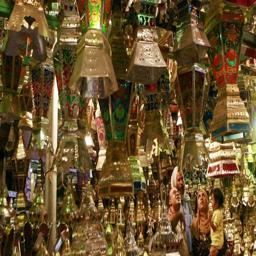

In [4]:
display(Image(filename='images/train/class/Places365_val_00030281.jpg'))

# Dataset

In [5]:
# class GrayscaleImageFolder(datasets.ImageFolder):
#     '''Custom images folder, which converts images to grayscale before loading'''
#     def __getitem__(self, index):
#         path, target = self.imgs[index]
#         img = self.loader(path)
# #         if self.transform is not None:
# #             img_original = self.transform(img)
#         img_original = np.asarray(img)
#         img_lab = rgb2lab(img_original)
#         img_lab = (img_lab + 128) / 255
#         img_ab = img_lab[:, :, 1:3]
#         img_ab = torch.from_numpy(img_ab.transpose((2, 0, 1))).float()
#         img_original = rgb2gray(img_original)
#         img_original = torch.from_numpy(img_original).unsqueeze(0).float()
# #         if self.target_transform is not None:
# #             target = self.target_transform(target)
#         return img_original, img_ab #, target

In [6]:
# # # train_transforms = transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])
# # # train_imagefolder = GrayscaleImageFolder('images/train', train_transforms)
# train_imagefolder = GrayscaleImageFolder('images/train')
# train_dl = torch.utils.data.DataLoader(train_imagefolder, batch_size=64, shuffle=True, num_workers=10)

In [7]:
# # # val_transforms = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224)])
# # # val_imagefolder = GrayscaleImageFolder('images/val' , val_transforms)
# val_imagefolder = GrayscaleImageFolder('images/val')
# val_dl = torch.utils.data.DataLoader(val_imagefolder, batch_size=64, shuffle=False)

In [8]:
class ImageDataset(Dataset):
    def __init__(self, files):
        self.files = np.array(files)
        self.length = len(files)
    
    def __getitem__(self, idx):
        img = imread(self.files[idx])
        if img.shape == (256, 256, 3):  # if a color image
            img_lab = rgb2lab(img)
            img_lab = (img_lab + [0, 128, 128]) / [100, 255, 255]  # normalize L, a, b dimensions
            img_lightness = img_lab[:, :, 0:1].transpose(2, 0, 1)
            img_ab = img_lab[:, :, 1:3].transpose(2, 0, 1)
        else:  # if a grayscale image
            img_lightness = (img/255)[None, :, :]
            img_ab = np.zeros(shape=(2, 256, 256))
        return img_lightness, img_ab
    
    def __len__(self):
        return self.length

In [9]:
train_files = glob.glob("images/train/class/*.jpg")
len(train_files)

29200

In [10]:
val_files = glob.glob("images/val/class/*.jpg")
len(val_files)

7300

In [11]:
train_ds = ImageDataset(train_files)
val_ds = ImageDataset(val_files)

In [ ]:
batch_size = 32
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=10)
val_dl = DataLoader(val_ds, batch_size=batch_size, num_workers=10)

In [ ]:
len(train_dl)

In [ ]:
in_, out_ = next(iter(train_dl))

In [ ]:
in_.shape

In [ ]:
out_.shape

# Model

In [ ]:
def basic_block(in_, out_, kernel_size=3, stride=1):
    """Return a block consisting of a conv2d, ReLU and BatchNorm2d layer."""
    padding = kernel_size // 2
    block = nn.Sequential(
        nn.Conv2d(in_, out_, kernel_size, stride, padding),
        nn.ReLU(),
        nn.BatchNorm2d(out_))
    return block

In [ ]:
class ColorizationNet(nn.Module):
    def __init__(self):
        super(ColorizationNet, self).__init__()
        self.layers = nn.Sequential(
            basic_block(1, 64, kernel_size=3, stride=2),
            basic_block(64, 128, kernel_size=3, stride=2),
            basic_block(128, 256, kernel_size=3, stride=2),
            basic_block(256, 512, kernel_size=3, stride=1),
            basic_block(512, 256, kernel_size=3, stride=1))
        self.upsample = nn.Upsample(scale_factor=8)
        self.out_layer = basic_block(256, 2, kernel_size=3, stride=1)
    
    def forward(self, x):
        x = self.layers(x)
        x = self.upsample(x)
        return self.out_layer(x)

In [ ]:
criterion = nn.MSELoss().cuda()

In [ ]:
def train_epoch(model, train_dl, val_dl, optimizer, epochs=10):
    iterations = len(train_dl) * epochs
    pbar = tqdm(total=iterations)
    best_val_loss = float("inf")
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total = 0
        for x, y in train_dl:
            x = x.float().cuda()
            y = y.float().cuda()
            y_hat = model(x)
            loss = criterion(y_hat, y)
            optimizer.zero_grad()
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
            optimizer.step()
            total_loss += loss.item() * y.shape[0]
            total += y.shape[0]
            pbar.update()
        val_loss = val_metrics(model, val_dl)
        print(f"train loss: {total_loss/total:.8f}\tval loss: {val_loss:.8f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            path = f"models/model_{best_val_loss:.6f}"
            save_model(model, path)
            print(path)
    
    return best_val_loss

In [ ]:
def val_metrics(model, val_dl):
    model.eval()
    total_loss = 0
    total = 0
    y_pred = []
    y_true = []
    
    for x, y in val_dl:
        x = x.float().cuda()
        y = y.float()
        out = model(x)
        loss = criterion(out, y.cuda())
        total_loss += loss.item() * y.shape[0]
        total += y.shape[0]
        y_pred.append(out.cpu().detach().numpy())
        y_true.append(y)
    
    y_pred = np.vstack(y_pred)
    y_true = np.vstack(y_true)
    return total_loss/total

In [ ]:
def save_model(model, path): torch.save(model.state_dict(), path)

def load_model(model, path): model.load_state_dict(torch.load(path))

In [ ]:
model = ColorizationNet().cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [ ]:
model, optimizer = amp.initialize(model, optimizer)

In [ ]:
best_val = train_epoch(model, train_dl, val_dl, optimizer, epochs=5)

# Check results

In [100]:
class AverageMeter(object):
    '''A handy class from the PyTorch ImageNet tutorial''' 
    def __init__(self):
        self.reset()
    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def to_rgb(grayscale_input, ab_input, save_path=None, save_name=None):
    '''Show/save rgb image from grayscale and ab channels
     Input save_path in the form {'grayscale': '/path/', 'colorized': '/path/'}'''
    plt.clf() # clear matplotlib 
    color_image = torch.cat((grayscale_input, ab_input), 0).numpy() # combine channels
    color_image = color_image.transpose((1, 2, 0))  # rescale for matplotlib
    color_image[:, :, 0:1] = color_image[:, :, 0:1] * 100
    color_image[:, :, 1:3] = color_image[:, :, 1:3] * 255 - 128   
    color_image = lab2rgb(color_image.astype(np.float64))
    grayscale_input = grayscale_input.squeeze().numpy()
    if save_path is not None and save_name is not None: 
        plt.imsave(arr=grayscale_input, fname='{}{}'.format(save_path['grayscale'], save_name), cmap='gray')
        plt.imsave(arr=color_image, fname='{}{}'.format(save_path['colorized'], save_name))

In [101]:
def validate(val_loader, model, criterion, save_images, epoch):
    model.eval()

  # Prepare value counters and timers
    batch_time, data_time, losses = AverageMeter(), AverageMeter(), AverageMeter()

    end = time.time()
    already_saved_images = False
    for i, (input_gray, input_ab) in enumerate(val_loader):
        data_time.update(time.time() - end)

    # Use GPU
    if use_gpu: input_gray, input_ab = input_gray.cuda(), input_ab.cuda()

    # Run model and record loss
    output_ab = model(input_gray) # throw away class predictions
    loss = criterion(output_ab, input_ab)
    losses.update(loss.item(), input_gray.size(0))

    # Save images to file
    if save_images and not already_saved_images:
        already_saved_images = True
    for j in range(min(len(output_ab), 10)): # save at most 5 images
        save_path = {'grayscale': 'outputs/gray/', 'colorized': 'outputs/color/'}
        save_name = 'img-{}-epoch-{}.jpg'.format(i * val_loader.batch_size + j, epoch)
        to_rgb(input_gray[j].cpu(), ab_input=output_ab[j].detach().cpu(), save_path=save_path, save_name=save_name)

    # Record time to do forward passes and save images
    batch_time.update(time.time() - end)
    end = time.time()

    # Print model accuracy -- in the code below, val refers to both value and validation
    if i % 25 == 0:
        print('Validate: [{0}/{1}]\t'
            'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
            'Loss {loss.val:.4f} ({loss.avg:.4f})\t'.format(
             i, len(val_loader), batch_time=batch_time, loss=losses))

    print('Finished validation.')
    return losses.avg

In [105]:
os.makedirs('outputs/color', exist_ok=True)
os.makedirs('outputs/gray', exist_ok=True)
os.makedirs('checkpoints', exist_ok=True)
save_images = True
best_losses = 1e10
epochs = 100

In [109]:
save_images = True
with torch.no_grad():
    validate(val_loader, model, criterion, save_images, 0)

KeyboardInterrupt: 

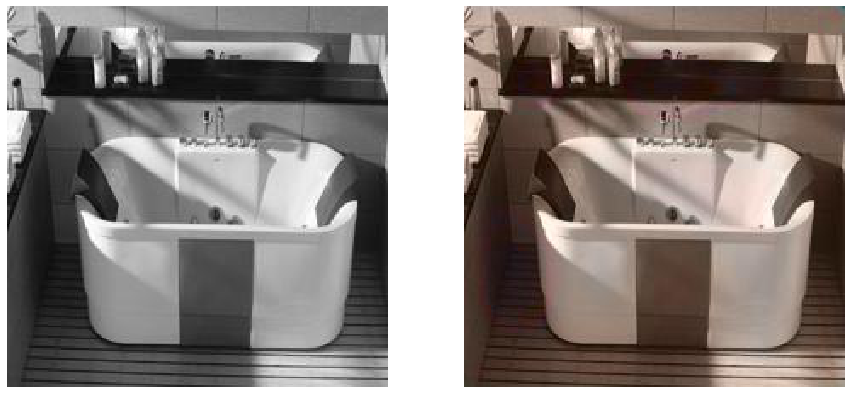

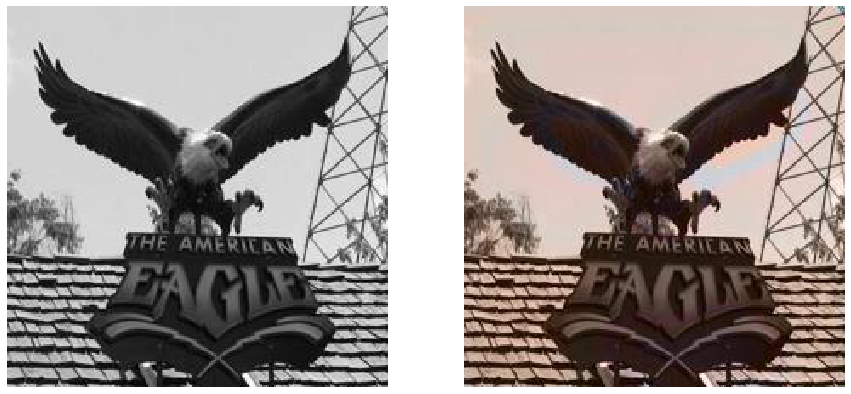

In [111]:
import matplotlib.image as mpimg
image_pairs = [('outputs/color/img-36480-epoch-0.jpg', 'outputs/gray/img-36480-epoch-0.jpg'),
               ('outputs/color/img-36484-epoch-0.jpg', 'outputs/gray/img-36484-epoch-0.jpg')]
for c, g in image_pairs:
    color = mpimg.imread(c)
    gray  = mpimg.imread(g)
    f, axarr = plt.subplots(1, 2)
    f.set_size_inches(15, 15)
    axarr[0].imshow(gray, cmap='gray')
    axarr[1].imshow(color)
    axarr[0].axis('off'), axarr[1].axis('off')
    plt.show()